# Figure 4: PSD of Elasser Variables //Fluctuations

- Panel (a): PSD of Elasser variables \& fit
- Panel (b): PSD of velocity/magnetic field fluctuations

In [2]:
import glob
import pyspedas
from pyspedas import time_string, time_double
from pytplot import tplot, get_data, cdf_to_tplot, store_data
import astrospice
import sunpy 
import sunpy.coordinates as scoords
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from scipy import stats


import sys, os
import datetime
import numpy as np
sys.path.append(os.path.realpath(''))
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt

import tools.utilities as utils
import tools.sigma as sigma
import tools.psp_funcs as psp_funcs
import tools.pfss_funcs as pfss_funcs
from tools.plotting import plot_pfss
from tools.settings import CsvDir, ImgDir, PlotDir, DataDir
import matplotlib.ticker as ticker
from scipy.signal.windows import tukey

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from datetime import timedelta

# for sc in ['psp','solar orbiter'] : kernels = astrospice.registry.get_kernels(sc,'predict') 

# REGIONS
loc_hcs = [61.8, 62.2]
loc_hcs1 = [357, 358.8]
ssw = [9, 19]
fsw = [42, 52]

# COLORS
scol, hcol, fcol, rcol = ['lavender', 'azure', 'lavenderblush', 'grey']
cc = ['lightpink', 'mediumspringgreen', 'peachpuff', 'powderblue', 'thistle', 'palegoldenrod']

# DIRECTORIES
RES_DIR = os.path.realpath('results')
FIG_DIR = os.path.realpath('figures')
EPS_DIR = os.path.realpath('eps_figures')
OBS_DIR = '/Users/tamarervin/products/csv_files/calcs/'
PlotDir = '/Users/tamarervin/mplstyle/'


# PLOT STYLING
plot_style = os.path.join(PlotDir, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.rcParams.update({'font.size': 20})
plt.style.use(plot_style)
plt.rcParams['axes.linewidth'] = 5

enc='E15'


# Data

In [3]:
# ### READ IN DATA ###
parker, parkerdownt, parkerdownl, pss, orbiter, orbiterdownl, orbiterdownt, oss, wind, winddownt, winddownl, wss = utils.read_data(RES_DIR, sigma_time=20, pp='parker20.csv')

### DEFINE REGIONS ###
lon_footpoints = parker.sslon
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
hhcs1 = np.logical_and(lon_footpoints >= loc_hcs1[0], lon_footpoints <=loc_hcs1[1])
slow = np.logical_and(lon_footpoints >=ssw[0], lon_footpoints <=ssw[1])
fast = np.logical_and(lon_footpoints >=fsw[0], lon_footpoints <=fsw[1])

19-Dec-23 16:58:11: /Users/tamarervin/publications/e15_conjunction/tools/utilities.py:169: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()

19-Dec-23 16:58:11: /Users/tamarervin/publications/e15_conjunction/tools/utilities.py:169: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()

19-Dec-23 16:58:14: /Users/tamarervin/publications/e15_conjunction/tools/utilities.py:178: FutureWarning: 'loffset' 

# PSD Calculation

## Period Identification

In [4]:
### RESAMPLE 
bin_size = pd.Timedelta(seconds=5)
pp = parker[slow].copy()

turb = pp.copy()
turb = turb.resample(bin_size, closed='left', label='left', loffset=bin_size / 2).ffill() 
turb['Time'] = turb.index
turb = turb.dropna()

ss, ii = 1400,3

### PERIOD ONE
use1 = np.logical_and(turb.Time >= pd.Timestamp('2023-03-16 12:00'), turb.Time <= pd.Timestamp('2023-03-16 18:00:00'))
t1 = turb[use1].copy()
tZp = [t1.Zp[i*ss:i*ss+ss] for i in range(0, ii)]
tZm = [t1.Zm[i*ss:i*ss+ss] for i in range(0, ii)]
tdv = [t1.deltav[i*ss:i*ss+ss] for i in range(0, ii)]
tdb = [t1.deltab[i*ss:i*ss+ss] for i in range(0, ii)]

### PERIOD TWO
use2 = np.logical_and(turb.Time >= pd.Timestamp('2023-03-17 00:00'), turb.Time <= pd.Timestamp('2023-03-17 17:00:00'))
t2 = turb[use2].copy()
tZp2 = [t2.Zp[i*ss:i*ss+ss] for i in range(0, ii)]
tZm2 = [t2.Zm[i*ss:i*ss+ss] for i in range(0, ii)]
tdv2 = [t2.deltav[i*ss:i*ss+ss] for i in range(0, ii)]
tdb2 = [t2.deltab[i*ss:i*ss+ss] for i in range(0, ii)]

### FULL 
ss, ii = 1400,6
use = np.logical_or(use1, use2)
t3 = turb[use].copy()
tZp3 = [t3.Zp[i*ss:i*ss+ss] for i in range(0, ii)]
tZm3 = [t3.Zm[i*ss:i*ss+ss] for i in range(0, ii)]
tdv3 = [t3.deltav[i*ss:i*ss+ss] for i in range(0, ii)]
tdb3 = [t3.deltab[i*ss:i*ss+ss] for i in range(0, ii)]


19-Dec-23 16:58:15: /var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_7606/2545277339.py:6: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  turb = turb.resample(bin_size, closed='left', label='left', loffset=bin_size / 2).ffill()



## Create Tukey Window

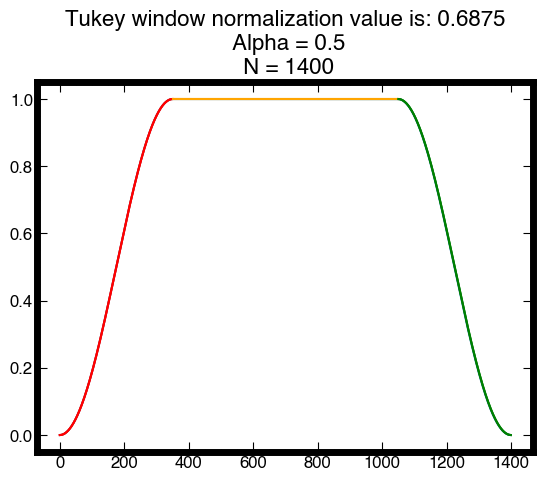

In [5]:
### CREATE TUKEY WINDOW
N=1400
alpha = 0.5  
tukey_window = tukey(N, alpha)
plt.plot(tukey_window)

ww = 1/2 * (1 - np.cos((2 * np.pi * np.arange(0, N * alpha / 2)) / (alpha * N)))
ww1 = 1/2 * (1 - np.cos((2 * np.pi * np.arange(N / 2 + N * alpha / 2, N)) / (alpha * N)))

# Create the piecewise function
x = np.arange(0, N * alpha / 2)
y1 = ww
x2 = np.arange(N * alpha / 2, N / 2 + N * alpha / 2)
y2 = np.ones(len(x2))
x3 = np.arange(N / 2 + N * alpha / 2, N)
y3 = ww1

# Plot each segment with a specified color
plt.plot(x, y1, color='red')
plt.plot(x2, y2, color='orange')
plt.plot(x3, y3, color='green')
### CALCULATE Wss
### Wss = 1/N * sum(w[n]) 
Wss = np.sum(np.concatenate((y1, y2, y3)) ** 2) / N
plt.title('Tukey window normalization value is: ' + str(Wss) + '\n Alpha = ' + str(alpha) + '\n N = ' + str(N))

# Plot each segment with a specified color
plt.plot(x, y1, color='red')
plt.plot(x2, y2, color='orange')
plt.plot(x3, y3, color='green')

## PSD Calculation

In [6]:
def windowed_psd(series):
    dff, dfp = pd.DataFrame(), pd.DataFrame()
    plt.figure()
    col=['red', 'green', 'blue', 'orange', 'purple', 'black']
    for i, time_series in enumerate(series):
        ### RESAMPLE DATA
        sample_rate = 1/5  # sample rate in seconds
        sample_freq = 1/sample_rate # sample frequency in Hz
        N = len(time_series)

        ### Create a Tukey window
        alpha = 0.5 
        tukey_window = tukey(N, alpha)
        windowed_time_series = time_series * tukey_window
        
        # Compute the FFT of the windowed time series
        fft_result = np.fft.fft(windowed_time_series) / N ## calculate FFT and normalize
        fft_freq = np.fft.fftfreq(len(fft_result), sample_freq)
        # fft_freq = fft_freq[:len(fft_freq) // 2]
        
        # Calculate the power spectral density
        power_spectrum = (2*N/sample_freq) * np.abs(fft_result)**2

        # normalize by the tukey window
        ww = 1/2 * (1 - np.cos((2 * np.pi * np.arange(0, N * alpha / 2)) / (alpha * N)))
        ww1 = 1/2 * (1 - np.cos((2 * np.pi * np.arange(N / 2 + N * alpha / 2, N)) / (alpha * N)))

        # Create the piecewise function
        y1 = ww
        x2 = np.arange(N * alpha / 2, N / 2 + N * alpha / 2)
        y2 = np.ones(len(x2))
        y3 = ww1

        ### CALCULATE Wss
        Wss = np.sum(np.concatenate((y1, y2, y3)) ** 2) / N
        power_spectrum /= Wss

        # Add to average
        dff[str(i)] = np.abs(fft_freq)
        dfp[str(i)] = power_spectrum
        
        plt.loglog(dff[str(i)], dfp[str(i)] , color=col[i])

    dfp['freq'] = dff.mean(axis=1)
    dfp['power'] = dfp.mean(axis=1)

    return dfp


### PERIOD ONE

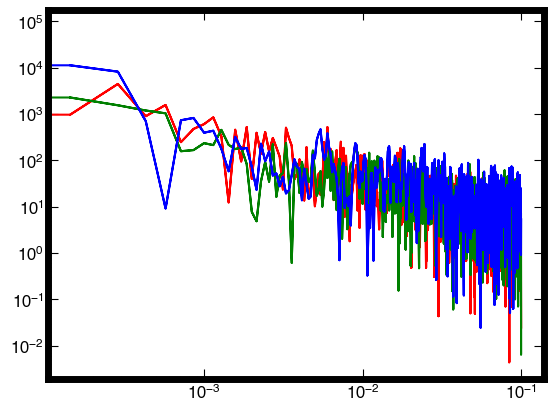

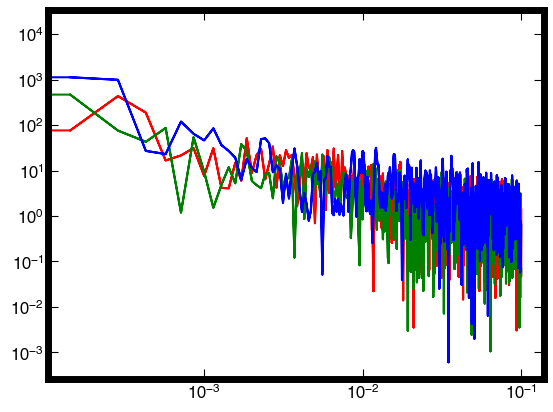

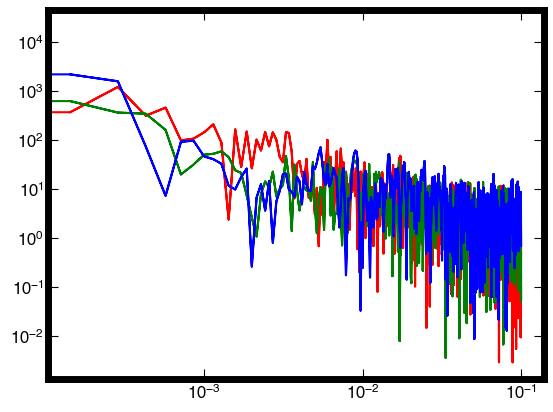

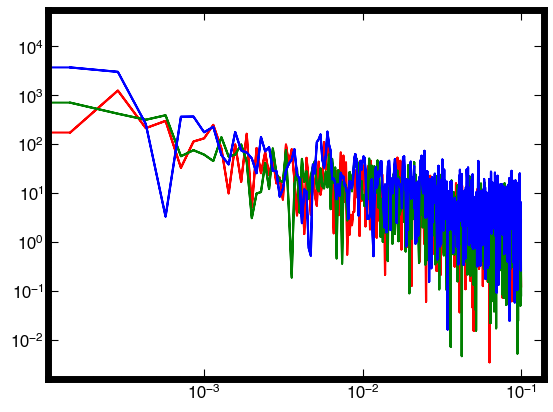

In [7]:
### Z plus
psd_Zp = windowed_psd(tZp)

### Z minus
psd_Zm = windowed_psd(tZm)

### Delta v
psd_dv = windowed_psd(tdv)

### Delta b
psd_db = windowed_psd(tdb)


### PERIOD TWO

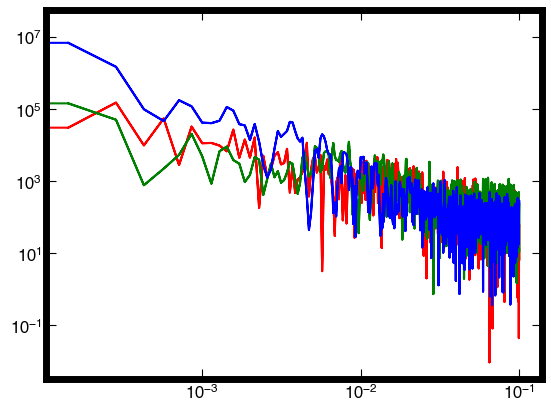

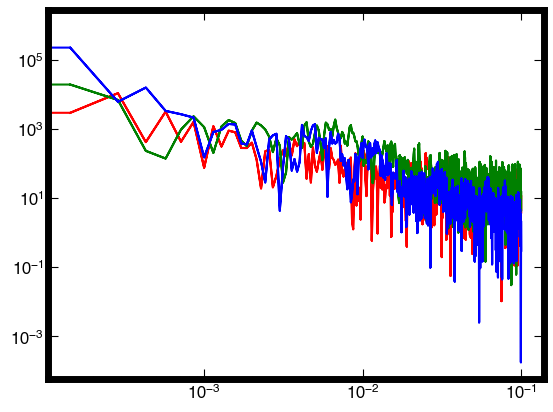

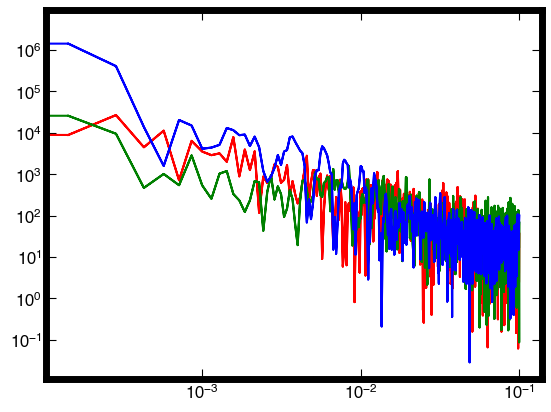

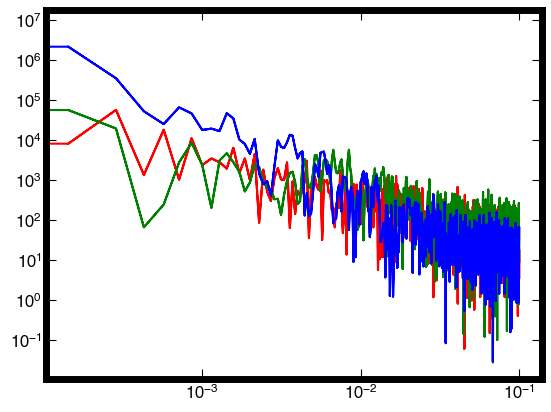

In [8]:
### Z plus
psd_Zp2 = windowed_psd(tZp2)

### Z minus
psd_Zm2 = windowed_psd(tZm2)

### Delta v
psd_dv2 = windowed_psd(tdv2)

### Delta b
psd_db2 = windowed_psd(tdb2)

# Spectral Fitting

In [9]:
def windowed_psd(time_series):
    dfp = pd.DataFrame()
    sample_rate =  1/5 # sample rate in seconds
    sample_freq = 1/sample_rate # sample frequency in Hz
    N =  len(time_series)

    ### Create a Tukey window
    alpha = 0.5 
    tukey_window = tukey(N, alpha)
    windowed_time_series = time_series * tukey_window

    # Compute the FFT of the windowed time series
    fft_result = np.fft.fft(windowed_time_series) / N ## calculate FFT and normalize
    fft_freq = np.fft.fftfreq(len(fft_result), sample_freq)

    # Calculate the power spectral density
    power_spectrum = (2*N/sample_freq) * np.abs(fft_result)**2

    # normalize by the tukey window
    ww = 1/2 * (1 - np.cos((2 * np.pi * np.arange(0, N * alpha / 2)) / (alpha * N)))
    ww1 = 1/2 * (1 - np.cos((2 * np.pi * np.arange(N / 2 + N * alpha / 2, N)) / (alpha * N)))

    # Create the piecewise function
    y1 = ww
    x2 = np.arange(N * alpha / 2, N / 2 + N * alpha / 2)
    y2 = np.ones(len(x2))
    y3 = ww1

    ### CALCULATE Wss
    ### Wss = 1/N * sum(w[n]) 
    Wss = np.sum(np.concatenate((y1, y2, y3)) ** 2) / N
    power_spectrum /= Wss

    dfp['freq'] = np.abs(fft_freq)
    dfp['power'] = power_spectrum

    return dfp


### FITTING FUNCTION

In [10]:
import numpy as np
from scipy.optimize import curve_fit
import tabulate

# Define your equations
def equation_p(x, Cp, Cinf):
    return Cp * (x**(-3/2)) + Cinf * (x**(-5/3))

def equation_m(x, Cm, Cinf, kt):
    return Cm * (x**(-3/2)) * np.sqrt(1 + np.sqrt(x/kt)) + Cinf * (x**(-5/3))

# Define the fit functions with a shared Cinf parameter
def fit_function_p(x, Cp, shared_Cinf):
    return equation_p(x, Cp, shared_Cinf)

def fit_function_m(x, Cm, shared_Cinf, kt):
    return equation_m(x, Cm, shared_Cinf, kt)

def var_p(x_values, covariance1):
    # Calculate the partial derivatives of Y with respect to Cp and Cinf
    partial_derivative_Cp = x_values**(-3/2)
    partial_derivative_Cinf = x_values**(-5/3)

    # Calculate the variance of Y
    variance_Y = (partial_derivative_Cp**2 * covariance1[0, 0] +
                partial_derivative_Cinf**2 * covariance1[1, 1] +
                2 * partial_derivative_Cp * partial_derivative_Cinf * covariance1[0, 1])

    # Calculate the standard error of Y
    standard_error_p = np.sqrt(variance_Y)
    return standard_error_p

def var_m(x_values, covariance2, kt_fit):
    partial_derivative_Cm = x_values**(-3/2) * np.sqrt(1 + np.sqrt(x_values/kt_fit))
    partial_derivative_Cinf = x_values**(-5/3)

    # Calculate the variance of Y without considering the error in kt
    variance_Y = (partial_derivative_Cm**2 * covariance2[0, 0] +
                  partial_derivative_Cinf**2 * covariance2[1, 1] +
                  2 * partial_derivative_Cm * partial_derivative_Cinf * covariance2[0, 1])

    # Calculate the standard error of Y
    standard_error_m = np.sqrt(variance_Y)
    return standard_error_m


## PERIOD ONE

Mean solar wind and Alfven speed and angle: 117.40520757622333 358.801991325539 114.25239294086244 deg


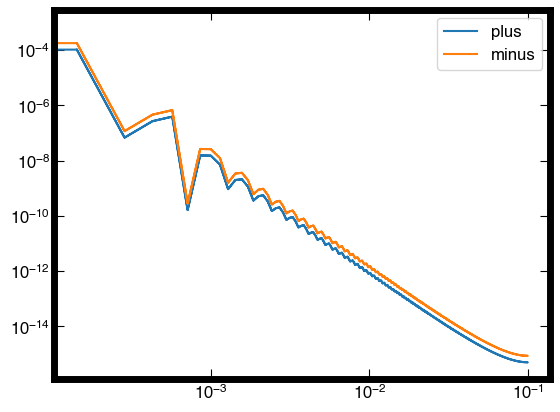

In [32]:
### MEAN VALUES
p1 = np.logical_and(parker.Time >= pd.Timestamp('2023-03-16 12:00'), parker.Time <= pd.Timestamp('2023-03-16 18:00:00'))
u0 = np.nanmean(parker.vr[p1])
vA0 = np.nanmean(parker.vA[p1])
ang = np.nanmean(parker.angle_vb[p1])*u.rad
print('Mean solar wind and Alfven speed and angle:', u0, vA0, (ang).to(u.deg))

### CALCULATE WAVE NUMBER 
freq = psd_Zp.freq # np.linspace(1e-4, 1e-2, num=len(psd_Zp.power))
kp = (2 * np.pi * freq)/(np.abs(u0 * np.cos(ang) - vA0))
km = (2 * np.pi * freq)/(np.abs(u0 * np.cos(ang) + vA0))

### CALCULATE POWER SPECTRA OF K+ AND K-

### CREATE DATAFRAME
data = {'freq': freq, 'kp': kp, 'km': km}
dfk = pd.DataFrame(data=data)

### PSD
psd_kp = windowed_psd(list(dfk.kp))
psd_km = windowed_psd(list(dfk.km))

### PLOT
plt.plot(psd_kp.freq, psd_kp.power, label='plus')
plt.plot(psd_km.freq, psd_km.power, label='minus')
plt.xscale('log')
plt.yscale('log')
len(psd_kp.power)
plt.legend()



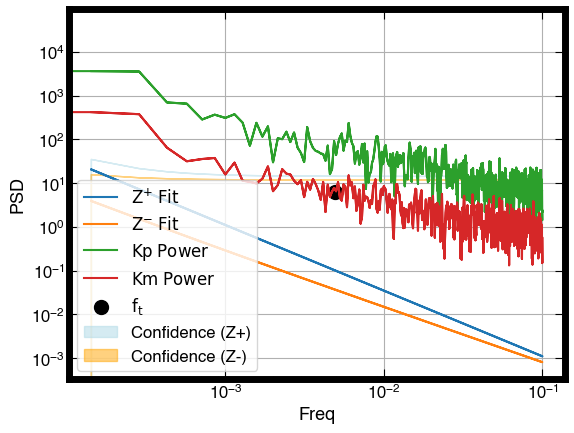

+-----------+--------------------+
| Parameter |    Fitted Value    |
+-----------+--------------------+
|  Cp_fit1  |     3.4851e-05     |
| Cinf_fit  |     5.3310e-25     |
|  Cm_fit2  |     4.4746e-06     |
|  kt_fit   |     1.0000e-04     |
|    ft     |     4.9430e-03     |
|  error_p  | 14.203956618161339 |
|  error m  | 11.684345480523264 |
+-----------+--------------------+


In [33]:
# Initial guesses for the parameters
initial_Cp_guess = 5e-3
initial_shared_Cinf_guess = 2.4e-7
initial_Cm_guess = 1e-4
initial_kt_guess = 1e-4


# Set bounds for the parameters
parameter_bounds1 = ([0, 0], [1e-1, 1e-1])  
parameter_bounds2 = ([0, 0, 1e-4], [1e-1, 1e-1, 1e-1])  

# For equation1, use initial_shared_Cinf_guess for Cinf and set bounds
use = np.logical_and(psd_Zp.freq>2e-3, psd_Zp.freq<2e-2)
paramsp, covariance1 = curve_fit(fit_function_p, dfk.kp[use], psd_Zp.power[use], p0=[initial_Cp_guess, initial_shared_Cinf_guess], bounds=parameter_bounds1)

# For equation2, use initial_shared_Cinf_guess for Cinf and set bounds
paramsm, covariance2 = curve_fit(fit_function_m, dfk.km[use], psd_Zm.power[use], p0=[initial_Cm_guess, initial_shared_Cinf_guess, initial_kt_guess], bounds=parameter_bounds2)

# Extract the optimized parameters
Cp_fit1, shared_Cinf_fit1= paramsp
Cm_fit1, shared_Cinf_fit1, kt_fit1 = paramsm

# Calculate ft
ft1 = (kt_fit1 / (2*np.pi)) * (np.abs(u0 * np.cos(np.nanmean(ang)) + np.nanmean(vA0)))


### ----- PLOT RESULTS ----- ####
x_values = psd_Zp.freq  # Adjust the range as needed
y1 = fit_function_p(freq, Cp_fit1, shared_Cinf_fit1)
y2 = fit_function_m(freq, Cm_fit1, shared_Cinf_fit1, kt_fit1)

plt.figure()
plt.plot(x_values, y1, label=r'$\rm Z^{+} \; Fit$')
plt.plot(x_values, y2, label=r'$\rm Z^{-} \; Fit$')
plt.plot(x_values, psd_Zp.power, label=r'$\rm Kp \; Power$')
plt.plot(x_values, psd_Zm.power, label=r'$\rm Km \; Power$')
plt.scatter(ft1, fit_function_m(kt_fit1, Cm_fit1, shared_Cinf_fit1, kt_fit1), label=r'$\rm f_t$', s=100, c='k')

### ERROR in P
errorp = var_p(dfk.kp, covariance1)

### ERROR IN M
errorm = var_m(dfk.km, covariance2, kt_fit1)

### PLOT ERROR
plt.fill_between(x_values, y1 - np.nanmean(errorp), y1 + np.nanmean(errorp), color='lightblue', alpha=0.5, label='Confidence (Z+)', zorder=-1)
plt.fill_between(x_values, y2 - np.nanmean(errorm), y2 + np.nanmean(errorm), color='orange', alpha=0.5, label='Confidence (Z-)', zorder=-1)


plt.xlabel("Freq")
plt.ylabel("PSD")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

# Print the results as a table in scientific notation
results_table = tabulate.tabulate([
    ["Cp_fit1", f"{Cp_fit1:.4e}"],
    ["Cinf_fit", f"{shared_Cinf_fit1:.4e}"],
    ["Cm_fit2", f"{Cm_fit1:.4e}"],
    ["kt_fit", f"{kt_fit1:.4e}"],
    ["ft", f"{ft1:.4e}"],
    ['error_p', np.nanmean(errorp)],
    ['error m', np.nanmean(errorm)]
], headers=["Parameter", "Fitted Value"], tablefmt="pretty")
print(results_table)

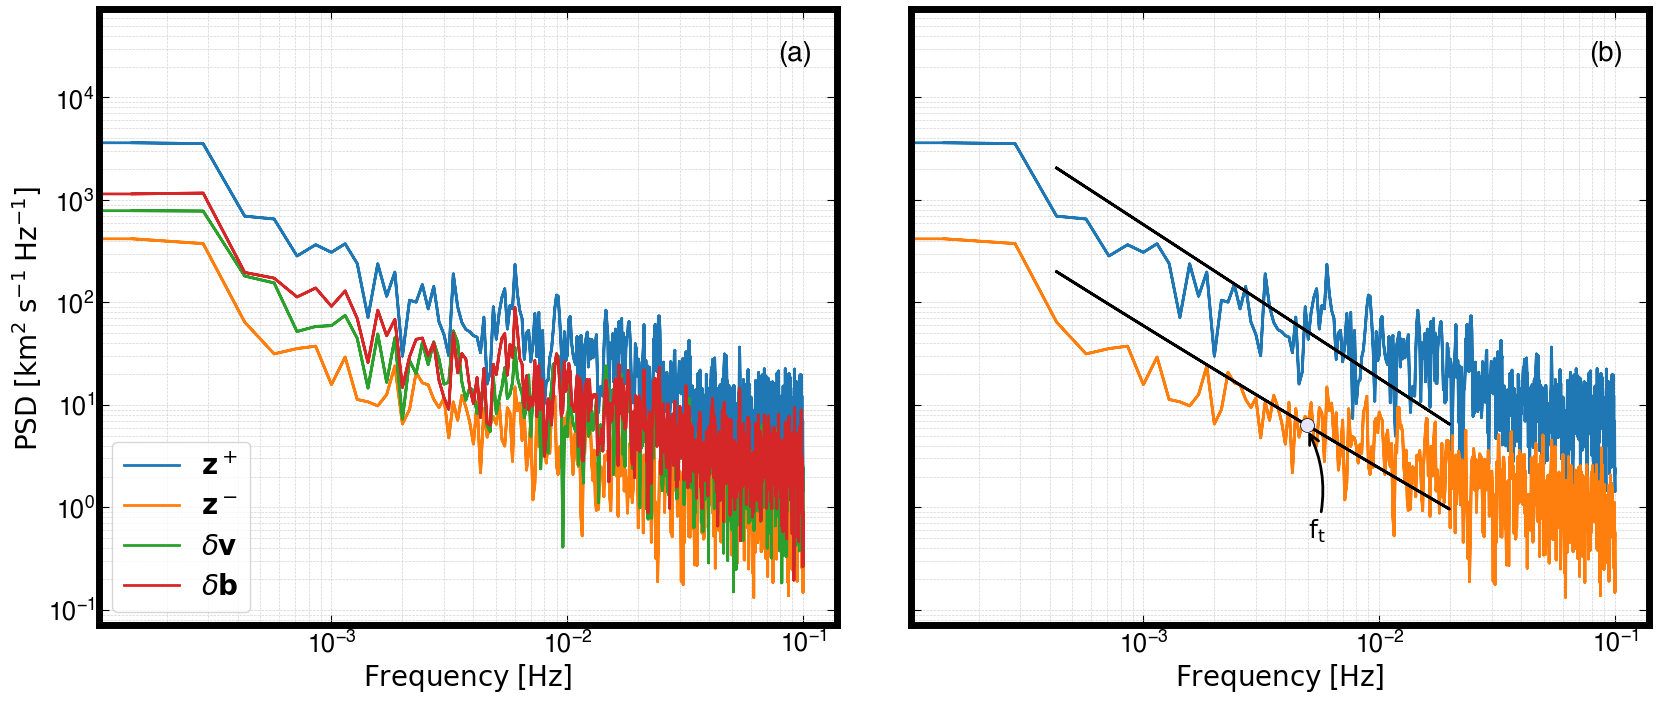

In [34]:
# Plot the PSD
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[20, 8], sharex='all', sharey='all', gridspec_kw={'hspace': 0.05, 'wspace':0.1})
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']
lw=2

##### -------- ELASSER SPECTRA #####
ax = ax1
for i, psd_spec in enumerate([psd_Zp, psd_Zm, psd_dv, psd_db]):
    ax.plot(psd_spec.freq, psd_spec.power, c=colors[i], label=labels[i], linewidth=lw)

### LEGEND
ax.legend(loc='lower left', fontsize=20)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

##### -------- PANEL TWO: SPECTRAL FITS #####
ax = ax2
for i, psd_spec in enumerate([psd_Zp, psd_Zm]):
    ax.plot(psd_spec.freq, psd_spec.power, c=colors[i], label=labels[i], linewidth=lw)

### PLOT FITS
use = np.logical_and(psd_Zp.freq>3e-4, psd_Zp.freq<2e-2)
freq = psd_Zp.freq[use]
kp = (2 * np.pi * freq)/(np.abs(u0 * np.cos(ang) - vA0))
km = (2 * np.pi * freq)/(np.abs(u0 * np.cos(ang) + vA0))
ap = (2 * np.pi)/(np.abs(u0 * np.cos(ang) - vA0))
am = (2 * np.pi)/(np.abs(u0 * np.cos(ang) + vA0))

y1 = fit_function_p(kp, Cp_fit1, shared_Cinf_fit1)
y2 = fit_function_m(km, Cm_fit1, shared_Cinf_fit1, kt_fit1) 

### MOVE TO FREQUENCY DOMAIN
ax.plot(freq, y1, c='k', lw=lw, zorder=2) 
ax.plot(freq, y2, c='k', lw=lw, zorder=2) 
# ax.plot(freq, 5e-3*(freq**(-3/2)), c='red', linestyle='dashed', lw=lw, zorder=2) 
ax.scatter(ft1, fit_function_m(kt_fit1, Cm_fit1, shared_Cinf_fit1, kt_fit1), s=100, c='lavender', edgecolor='k', lw=0.5, zorder=3)

### ANNOTATE Ft
ax.annotate(r'$\rm f_t$', xy=(ft1, fit_function_m(kt_fit1, Cm_fit1, shared_Cinf_fit1, kt_fit1)-0.5), xytext=(5e-3, .5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=2),fontsize=18, zorder=10)

### LABELS
ax.text(0.92, 0.95, '(b)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 

### SCALES
ax2.set_xscale('log')  
ax2.set_yscale('log')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')



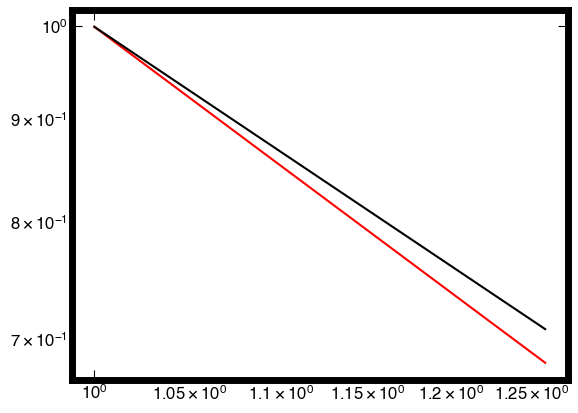

In [13]:
f = np.logspace(1e-4, 1e-1)
plt.loglog(f, f**(-5/3), color='red')
plt.loglog(f, f**(-3/2), color='k')

## PERIOD TWO

Mean solar wind and Alfven speed and angle: 248.87977126858277 684.1639196733811 2.0139667604228606 rad


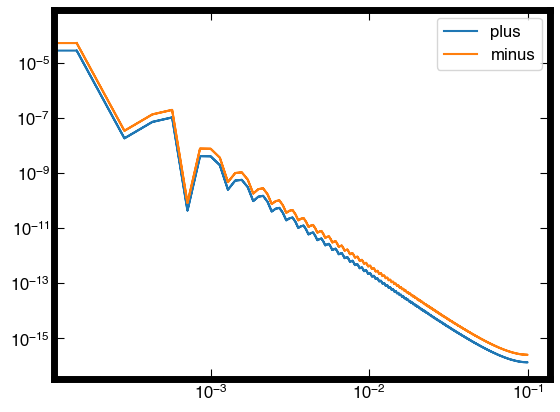

In [14]:
### MEAN VALUES
p2 = np.logical_and(parker.Time >= pd.Timestamp('2023-03-17 00:00'), parker.Time <= pd.Timestamp('2023-03-17 06:00:00'))
u02 = np.nanmean(parker.vr[p2])
vA02 = np.nanmean(parker.vA[p2])
ang2 = np.nanmean(parker.angle_vb[p2])*u.rad
print('Mean solar wind and Alfven speed and angle:', u02, vA02, ang2)

### CALCULATE WAVE NUMBER 
freq = psd_Zp2.freq
kp = (2 * np.pi * freq)/(np.abs(u02 * np.cos(ang2) - vA02))
km = (2 * np.pi * freq)/(np.abs(u02 * np.cos(ang2) + vA02))

### CALCULATE POWER SPECTRA OF K+ AND K-

### CREATE DATAFRAME
data = {'freq': freq, 'kp': kp, 'km': km}
dfk2 = pd.DataFrame(data=data)

### K plus
psd_kp2 = windowed_psd(list(dfk2.kp))
psd_km2 = windowed_psd(list(dfk2.km))

### Z minus
plt.plot(psd_kp2.freq, psd_kp2.power, label='plus')
plt.plot(psd_kp2.freq, psd_km2.power, label='minus')
plt.xscale('log')
plt.yscale('log')
len(psd_kp2.power)
plt.legend()




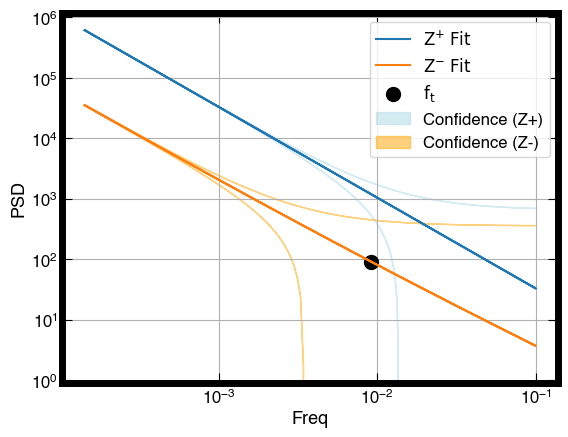

+-----------+-------------------+
| Parameter |   Fitted Value    |
+-----------+-------------------+
|  Cp_fit2  |    7.3493e-04     |
| Cinf_fit  |    1.1763e-15     |
|  Cm_fit2  |    6.3849e-05     |
|  kt_fit   |    1.0000e-04     |
|    ft     |    9.1903e-03     |
|  error_p  | 654.6541393669454 |
|  error m  | 353.9306964771972 |
+-----------+-------------------+


In [15]:
# Initial guesses for the parameters
initial_Cp_guess = 5e-3
initial_shared_Cinf_guess = 2.4e-7
initial_Cm_guess = 1e-4
initial_kt_guess = 1e-4

# Set bounds for the parameters
parameter_bounds1 = ([0, 0], [1e-1, 1e-1])  
parameter_bounds2 = ([0, 0, 1e-4], [1e-1, 1e-1, 1e-1])  

# For equation1, use initial_shared_Cinf_guess for Cinf and set bounds
use = np.logical_and(psd_Zp.freq>2e-3, psd_Zp.freq<2e-2)
paramsp, covariance1 = curve_fit(fit_function_p, dfk2.kp[use], psd_Zp2.power[use], p0=[initial_Cp_guess, initial_shared_Cinf_guess], bounds=parameter_bounds1, method='trf')

# For equation2, use initial_shared_Cinf_guess for Cinf and set bounds
paramsm, covariance2 = curve_fit(fit_function_m, dfk2.km[use], psd_Zm2.power[use], p0=[initial_Cm_guess, initial_shared_Cinf_guess, initial_kt_guess], bounds=parameter_bounds2, method='trf')

# Extract the optimized parameters
Cp_fit2, shared_Cinf_fit2 = paramsp
Cm_fit2, shared_Cinf_fit2, kt_fit2 = paramsm

# Calculate ft
ft2 = (kt_fit2 / (2*np.pi)) * (np.abs(u02 * np.cos(np.nanmean(ang2)) + np.nanmean(vA02)))


### ----- PLOT RESULTS ----- ####
x_values = freq  # Adjust the range as needed
y1 = fit_function_p(dfk2.kp, Cp_fit2, shared_Cinf_fit2)
y2 = fit_function_m(dfk2.km, Cm_fit2, shared_Cinf_fit2, kt_fit2)

plt.figure()
plt.plot(x_values, y1, label=r'$\rm Z^{+} \; Fit$')
plt.plot(x_values, y2, label=r'$\rm Z^{-} \; Fit$')
plt.scatter(ft2, fit_function_m(kt_fit2, Cm_fit2, shared_Cinf_fit2, kt_fit2), label=r'$\rm f_t$', s=100, c='k')

### ERROR in P
errorp = var_p(dfk2.kp, covariance1)

### ERROR IN M
errorm = var_m(dfk2.km, covariance2, kt_fit2)

### PLOT ERROR
plt.fill_between(x_values, y1 - np.nanmean(errorp), y1 + np.nanmean(errorp), color='lightblue', alpha=0.5, label='Confidence (Z+)', zorder=-1)
plt.fill_between(x_values, y2 - np.nanmean(errorm), y2 + np.nanmean(errorm), color='orange', alpha=0.5, label='Confidence (Z-)', zorder=-1)

plt.xlabel("Freq")
plt.ylabel("PSD")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

# Print the results as a table in scientific notation
results_table = tabulate.tabulate([
    ["Cp_fit2", f"{Cp_fit2:.4e}"],
    ["Cinf_fit", f"{shared_Cinf_fit2:.4e}"],
    ["Cm_fit2", f"{Cm_fit2:.4e}"],
    ["kt_fit", f"{kt_fit2:.4e}"],
    ["ft", f"{ft2:.4e}"],
    ['error_p', np.nanmean(errorp)],
    ['error m', np.nanmean(errorm)]
], headers=["Parameter", "Fitted Value"], tablefmt="pretty")
print(results_table)

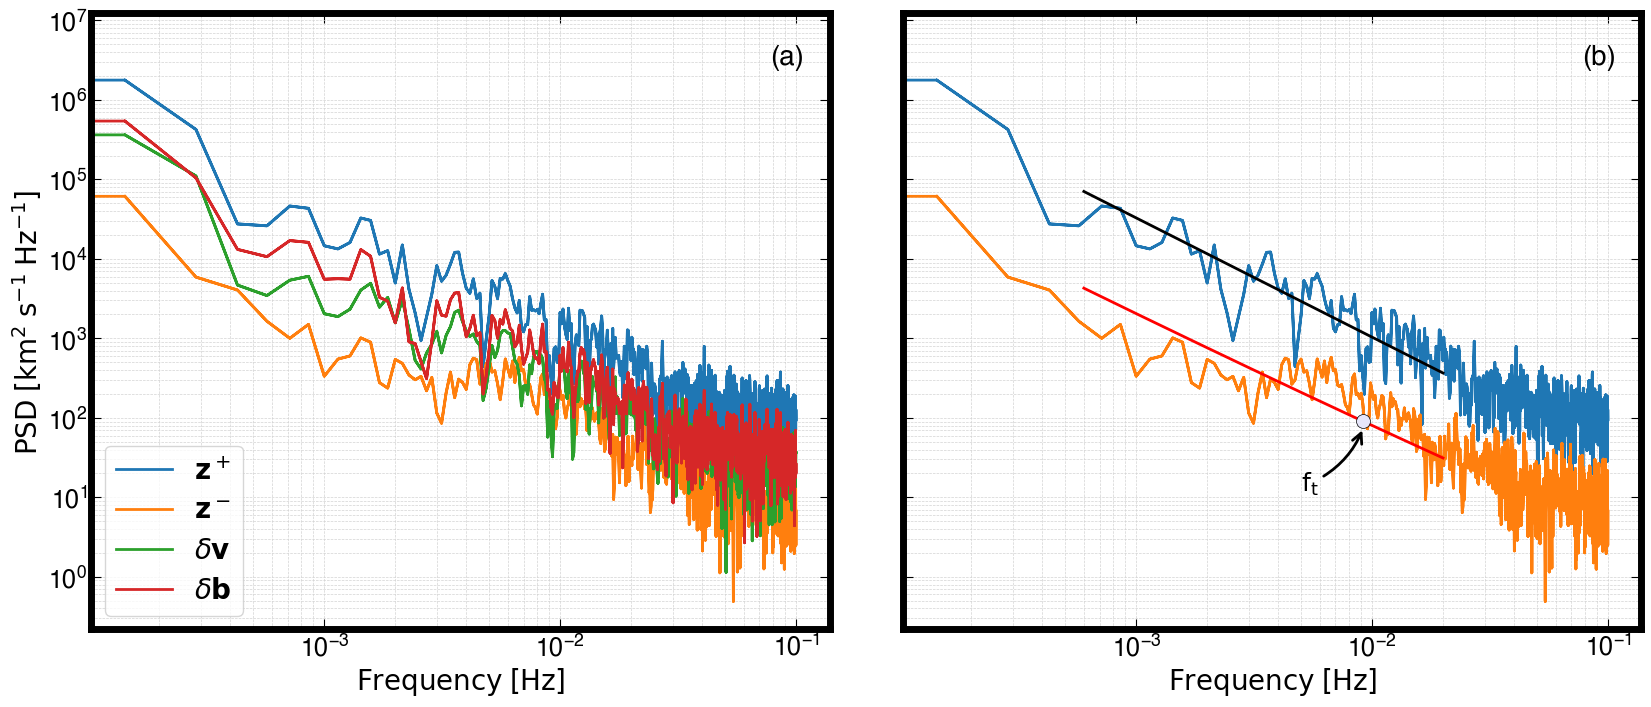

In [16]:
# Plot the PSD

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[20, 8], sharex='all', sharey='all', gridspec_kw={'hspace': 0.05, 'wspace':0.1})
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']
lw=2
##### -------- ELASSER SPECTRA #####
ax = ax1
for i, psd_spec in enumerate([psd_Zp2, psd_Zm2, psd_dv2, psd_db2]):
    ax.plot(psd_spec.freq, psd_spec.power, c=colors[i], label=labels[i], linewidth=lw)
### LEGEND
ax.legend(loc='lower left', fontsize=20)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

##### -------- PANEL TWO: SPECTRAL FITS #####
freq = psd_Zp.freq
ax = ax2
for i, psd_spec in enumerate([psd_Zp2, psd_Zm2]):
    ax.plot(psd_spec.freq, psd_spec.power, c=colors[i], label=labels[i], linewidth=lw)

### PLOT FITS
freq = np.linspace(6e-4, 2e-2, num=len(kp))
kp = (2 * np.pi * freq)/(np.abs(u02 * np.cos(ang2) - vA02))
km = (2 * np.pi * freq)/(np.abs(u02 * np.cos(ang2) + vA02))
y1 = fit_function_p(kp, Cp_fit2, shared_Cinf_fit2) 
y2 = fit_function_m(km, Cm_fit2, shared_Cinf_fit2, kt_fit2)

ax.plot(freq, y1, c='k', lw=lw, zorder=2) # label=r'$\rm Z^{+} \; Fit$', 
ax.plot(freq, y2, c='red', lw=lw, zorder=2) #label=r'$\rm Z^{-} \; Fit$', 
ax.scatter(ft2, fit_function_m(kt_fit2, Cm_fit2, shared_Cinf_fit2, kt_fit2), s=100, c='lavender', edgecolor='k', lw=0.5, zorder=3)

### PLOT ERROR
### ERROR in P
errorp = var_p(kp, covariance1)
errorm = var_m(km, covariance2, kt_fit2)
# ax.fill_between(freq, y1 - errorp, y1 + errorp, color='lightblue', alpha=0.5, zorder=1)
# ax.fill_between(freq, y2 - errorm, y2 + errorm, color='lightgreen', alpha=0.5, zorder=1)

### ANNOTATE Ft
ax.annotate(r'$\rm f_t$', xy=(ft2, fit_function_m(kt_fit2, Cm_fit2, shared_Cinf_fit2, kt_fit2)-15), xytext=(5e-3, 12),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=2),fontsize=18)

### LEGEND
# ax.legend(loc='lower left', fontsize=20)

### LABELS
ax.text(0.92, 0.95, '(b)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 

### SCALES
ax2.set_xscale('log')  
ax2.set_yscale('log')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')



# Figure 4: PSD of Elasser Variables & Fluctuations

- Panels (a)/(c): Elasser variable spectra + fits
- Panels (b)/(d): fluctuation spectra 

19-Dec-23 12:20:59: /var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_49372/2296983970.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()

19-Dec-23 12:21:06: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


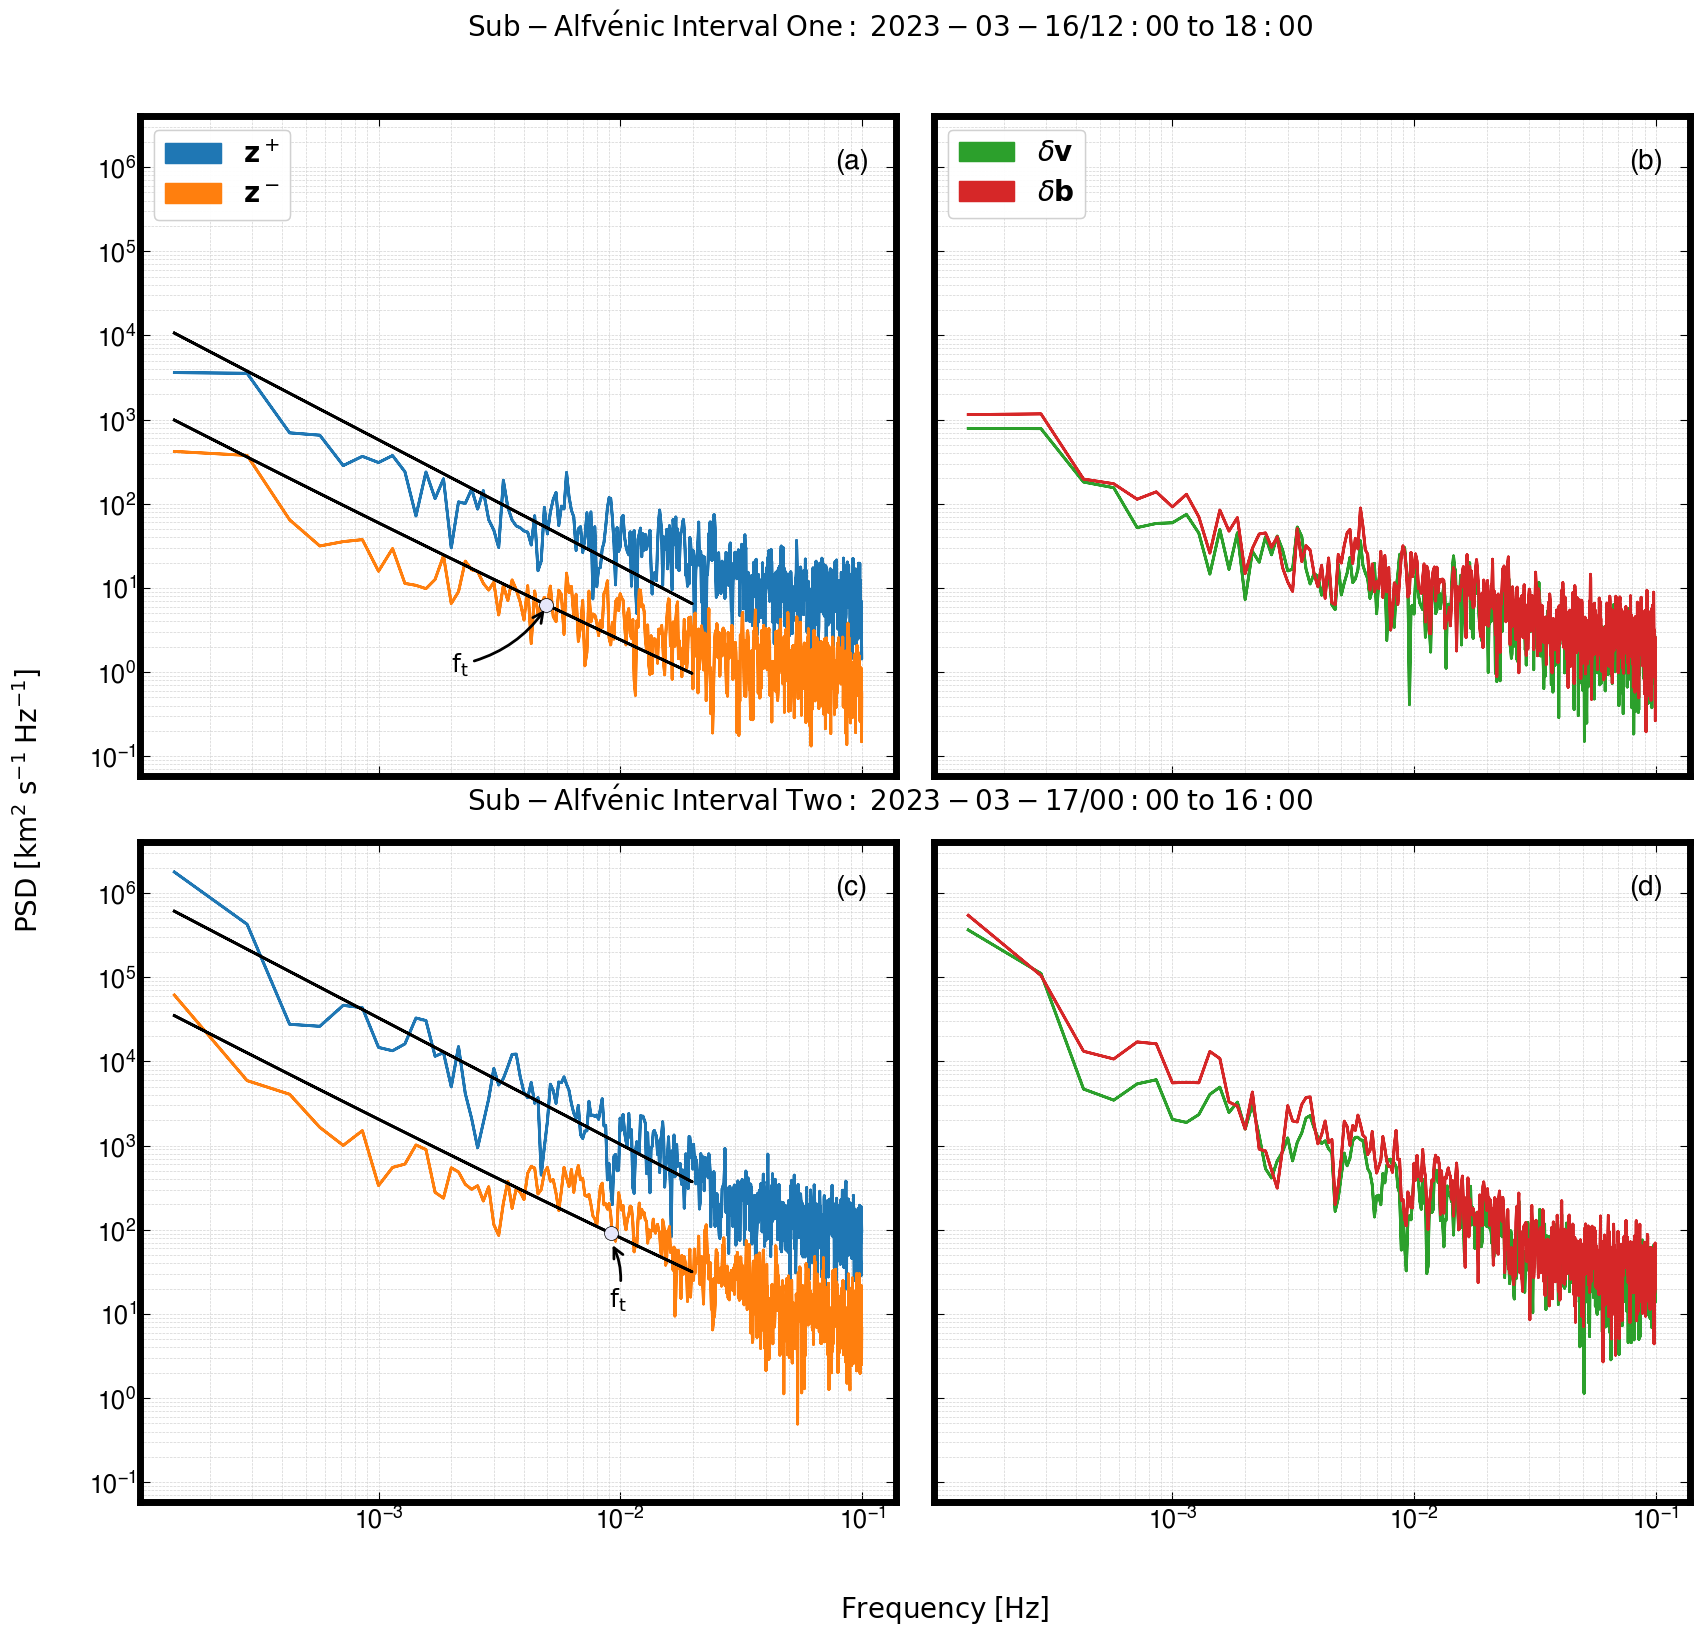

In [29]:
# Plot the PSD
fig, axs = plt.subplots(2, 2, figsize=[20, 18], sharex='all', sharey='all', gridspec_kw={'wspace':0.05, 'hspace':0.10})

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']
lw=2

### ------------------------------------------------------- ###
            ##### -------- INTERVAL ONE -------- #####
### ------------------------------------------------------- ###

##### -------- PANEL ONE: ELASSER SPECTRA -------- #####
ax = axs[0][0]
good = np.logical_and(np.array(psd_Zp.freq)<=1, np.array(psd_Zp.freq)>=1e-4)
for i, psd_spec in enumerate([psd_Zp, psd_Zm]):
    ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i], label=labels[i], linewidth=lw)
# ax.axvline(1e-1, c='k', linestyle='dashed', lw=2, zorder=0)

### PLOT FITS
use = np.logical_and(psd_Zp.freq>1e-4, psd_Zp.freq<2e-2)
freq = psd_Zp.freq[use]
kp = (2 * np.pi * freq)/(np.abs(u0 * np.cos(ang) - vA0))
y1 = fit_function_p(kp, Cp_fit1, shared_Cinf_fit1) 
ax.plot(freq, y1, c='k', lw=lw, zorder=2) 

# freq = np.linspace(1e-3, 2e-2, num=len(km))
km = (2 * np.pi * freq)/(np.abs(u0 * np.cos(ang) + vA0))
y2 = fit_function_m(km, Cm_fit1, shared_Cinf_fit1, kt_fit1)
ax.plot(freq, y2, c='k', lw=lw, zorder=2)  

### THRESHOLD FREQUENCY
ax.scatter(ft1, fit_function_m(kt_fit1, Cm_fit1, shared_Cinf_fit1, kt_fit1), s=100, c='lavender', edgecolor='k', lw=0.5, zorder=3)
ax.annotate(r'$\rm f_t$',  xy=(ft1, fit_function_m(kt_fit1, Cm_fit1, shared_Cinf_fit1, kt_fit1)-0.5), xytext=(2e-3, 1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=2),fontsize=18)

### LEGEND ###
zp_patch = mpatches.Patch(color=colors[0], label=labels[0])
zm_patch = mpatches.Patch(color=colors[1], label=labels[1])
leg0 = ax.legend(handles=[zp_patch, zm_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

##### -------- PANEL TWO: SPECTRAL FITS -------- #####
ax = axs[0][1]
freq = psd_Zp.freq
good = np.logical_and(np.array(freq)<=1, np.array(freq)>=1e-4)
for i, psd_spec in enumerate([psd_dv, psd_db]):
    ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i+2], label=labels[i+2], linewidth=lw, zorder=1)


### LEGEND ###
dv_patch = mpatches.Patch(color=colors[2], label=labels[2])
db_patch = mpatches.Patch(color=colors[3], label=labels[3])
leg0 = ax.legend(handles=[dv_patch, db_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)

### LABELS
ax.text(0.92, 0.95, '(b)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', which='major', labelsize=18) 

### SCALES
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray', zorder=-4)

### ------------------------------------------------------- ###
            ##### -------- INTERVAL TWO -------- #####
### ------------------------------------------------------- ###

##### -------- PANEL THREE: ELASSER SPECTRA (P2) -------- #####
ax = axs[1][0]
good = np.logical_and(np.array(psd_Zp2.freq)<=1, np.array(psd_Zp2.freq)>=1e-4)
for i, psd_spec in enumerate([psd_Zp2, psd_Zm2]):
    ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i], label=labels[i], linewidth=lw)

### PLOT FITS
use = np.logical_and(psd_Zp.freq>1e-4, psd_Zp.freq<2e-2)
freq = psd_Zp.freq[use]
kp = (2 * np.pi * freq)/(np.abs(u02 * np.cos(ang2) - vA02))
y1 = fit_function_p(kp, Cp_fit2, shared_Cinf_fit2) 
ax.plot(freq, y1, c='k', lw=lw, zorder=2) 

km = (2 * np.pi * freq)/(np.abs(u02 * np.cos(ang2) + vA02))
y2 = fit_function_m(km, Cm_fit2, shared_Cinf_fit2, kt_fit2)
ax.plot(freq, y2, c='k', lw=lw, zorder=2)  

### THRESHOLD FREQUENCY
ax.scatter(ft2, fit_function_m(kt_fit2, Cm_fit2, shared_Cinf_fit2, kt_fit2), s=100, c='lavender', edgecolor='k', lw=0.5, zorder=3)
ax.annotate(r'$\rm f_t$',  xy=(ft2, fit_function_m(kt_fit2, Cm_fit2, shared_Cinf_fit2, kt_fit2)-20), xytext=(9e-3, 12),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=2),fontsize=18)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(c)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

##### -------- PANEL FOUR: SPECTRAL FITS (P2) -------- #####
ax = axs[1][1]
freq = psd_Zp2.freq
good = np.logical_and(np.array(freq)<=1, np.array(freq)>=1e-4)
for i, psd_spec in enumerate([psd_dv2, psd_db2]):
    ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i+2], label=labels[i+2], linewidth=lw, zorder=1)

### LABELS
ax.text(0.92, 0.95, '(d)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
# ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 

### SCALES
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray', zorder=-4)
# ax.axvline(1e-1, c='k', linestyle='dashed', lw=2, zorder=-1)


### ADD PANEL LABELS 
fig.text(0.06, 0.5, r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20, va='center', rotation='vertical')
fig.text(0.475, 0.05, r'$\rm Frequency \; [Hz]$', fontsize=20, va='center', rotation='horizontal')

### TITLES
fig.text(0.5, 0.93, r'$\rm Sub-Alfv\'enic \; Interval \; One: \; 2023-03-16/12:00 \; to \; 18:00$', fontsize=20, ha='center', va='center', rotation='horizontal') # period one
fig.text(0.5, 0.50, r'$\rm Sub-Alfv\'enic \; Interval \; Two: \; 2023-03-17/00:00 \; to \; 16:00$', fontsize=20, ha='center', va='center', rotation='horizontal') # period two

### SAVE FIGURE
plt.tight_layout()
plt.savefig(os.path.realpath(os.path.join(FIG_DIR, 'fig4.png')), bbox_inches='tight')
plt.savefig(os.path.realpath(os.path.join(EPS_DIR, 'fig4.eps')), bbox_inches='tight')



# Noise PSD

In [25]:
### ----- calculate spectra for noise ------ ###
N = len(psd_Zp.freq)  # Number of samples
refspec, sn = [], []
for i, vv in enumerate([1, 3, 5]):
    speed = 100
    noise_level = vv  # Amplitude of the noise in km/s
    sample_freq = 1

    # Generate a constant signal with some noise
    signal = np.ones(N) * speed
    noise = np.random.normal(0, noise_level, N)  # Generate random noise
    data_km_per_s = signal + noise

    # Compute the FFT of the windowed time series (as previously calculated)
    fft_result = np.fft.fft(data_km_per_s)

    # Compute the FFT of the windowed time series
    fft_result = np.fft.fft(data_km_per_s) / N ## calculate FFT and normalize
    fft_freq = np.fft.fftfreq(len(fft_result), sample_freq)
    fft_freq = fft_freq[:len(fft_freq) // 2]
    
    # Calculate the power spectral density
    ref_spec = (2*N/sample_freq) * np.abs(fft_result)**2

    sn.append(data_km_per_s)
    refspec.append(ref_spec)
freq = psd_Zp.freq
good = np.logical_and(np.array(freq)<=1, np.array(freq)>=3e-4)
freq = freq
refspec = [r for r in refspec]

## Noise Comparison -- Visual

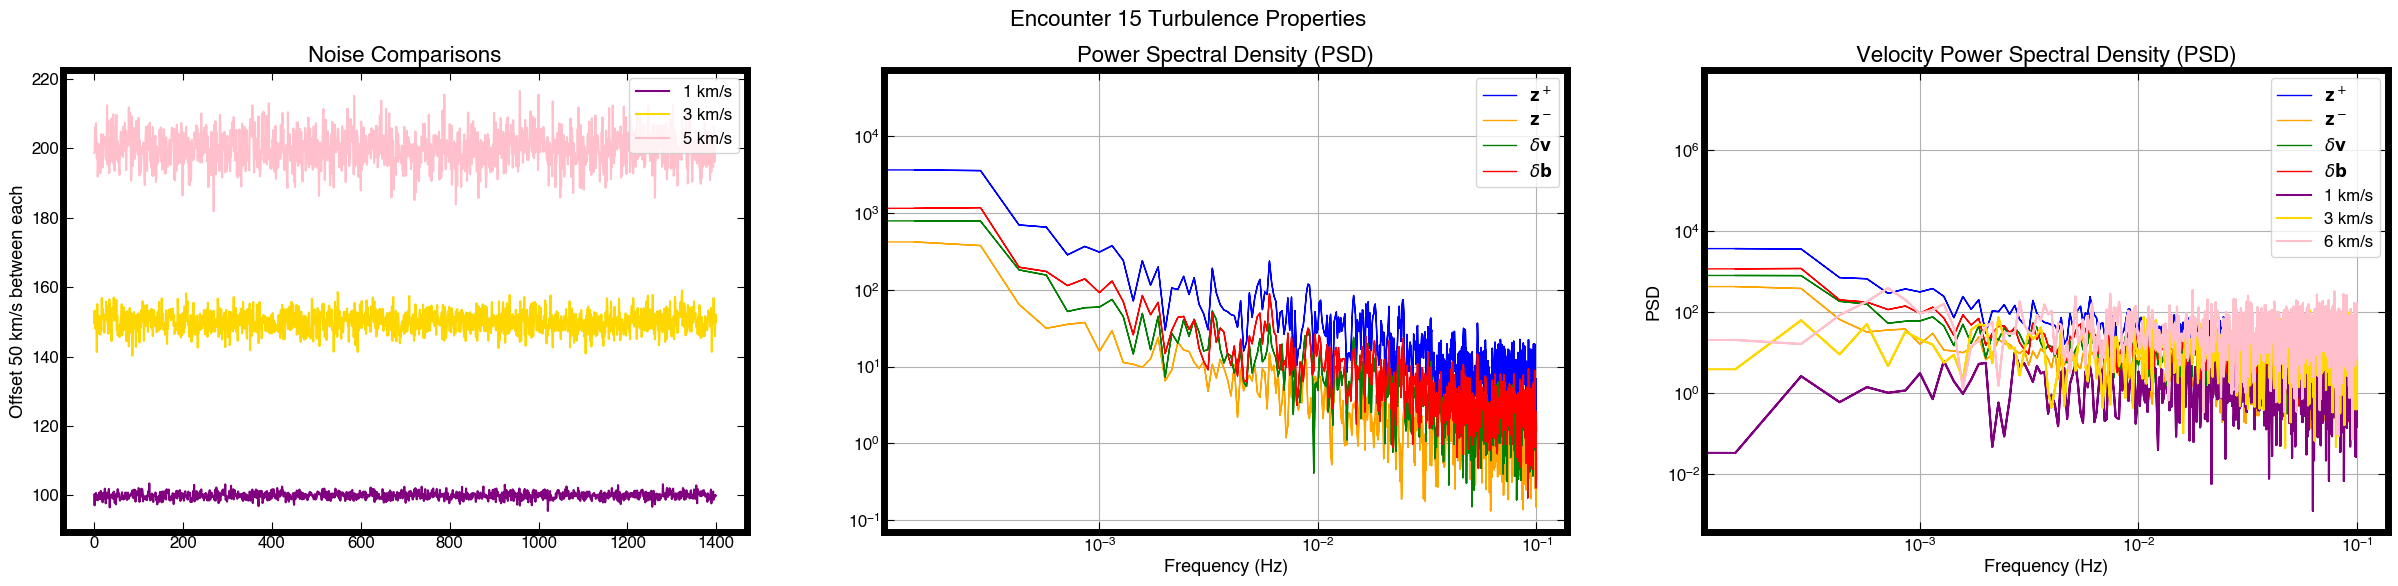

In [26]:
# Plot the PSD

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=[30, 6])
colors = ['blue', 'orange', 'green', 'red']
labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']

##### NOISE COMPARISON #####
lab = ['1 km/s', '3 km/s', '5 km/s']
col = ['purple', 'gold', 'pink']
xy=[0, 50, 100]
for i, xx in enumerate(sn):
    ax1.plot(xx+xy[i], c=col[i], label=lab[i])

ax1.set_ylabel('Offset 50 km/s between each')
ax1.set_title('Noise Comparisons')
ax1.legend()

##### SPECTRA #####
freq = psd_Zp.freq
for i, psd_spec in enumerate([psd_Zp, psd_Zm, psd_dv, psd_db]):
    ax2.plot(psd_spec.freq, psd_spec.power, c=colors[i], label=labels[i], linewidth=1)

ax2.legend(loc='upper right')
ax2.set_title('Power Spectral Density (PSD)')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_xscale('log')  
ax2.set_yscale('log')
ax2.grid(True)

##### NOISE + SPECTRA #####
for i, psd_spec in enumerate([psd_Zp, psd_Zm, psd_dv, psd_db]):
    ax3.plot(psd_spec.freq, psd_spec.power, c=colors[i], label=labels[i], linewidth=1)
ax3.plot(freq, refspec[0], label='1 km/s', color=col[0])
ax3.plot(freq, refspec[1], label='3 km/s', color=col[1])
ax3.plot(freq, refspec[2], label='6 km/s', color=col[2])
ax3.legend(loc='upper right')
ax3.set_title('Velocity Power Spectral Density (PSD)')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('PSD')  
ax3.set_xscale('log')  
ax3.set_yscale('log')
ax3.grid(True)
# plt.savefig('PSD.png')


plt.suptitle('Encounter 15 Turbulence Properties')
plt.show()

# Appendix B: Figure 10 

- Panel (a): Timeseries of offset values
- Panel (b): PSD plot of noise measurements (log/log)

19-Dec-23 12:21:15: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


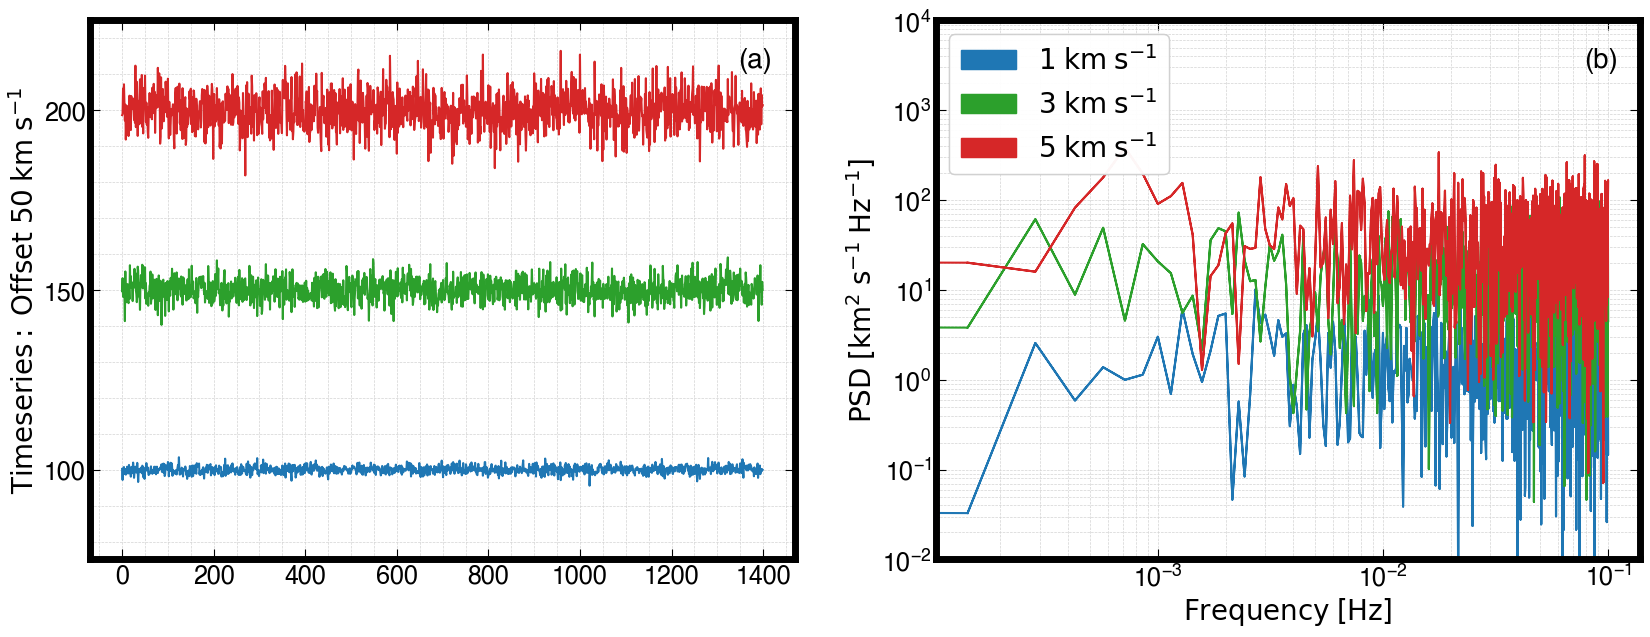

In [30]:
# Plot the PSD

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[20, 7])

labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']

##### NOISE COMPARISON #####
ax = ax1
lab = [r'$\rm 1 \; km \; s^{-1}$', r'$\rm 3 \; km \; s^{-1}$', r'$\rm 5 \; km \; s^{-1}$']
col = ['tab:blue', 'tab:green', 'tab:red']
xy=[0, 50, 100]
for i, xx in enumerate(sn):
    ax1.plot(xx+xy[i], c=col[i], label=lab[i])

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_ylabel(r'$\rm Timeseries: \; Offset \; 50 \; km \; s^{-1}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
ax.set(ylim=(75, 225), yticks=np.arange(100, 231, step=50))

##### SPECTRA #####
ax = ax2
ax.plot(freq, refspec[0], label=r'$\rm 1 \; km \; s^{-1}$', color=col[0])
ax.plot(freq, refspec[1], label=r'$\rm 3 \; km \; s^{-1}$', color=col[1])
ax.plot(freq, refspec[2], label=r'$\rm 5 \; km \; s^{-1}$', color=col[2])

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(b)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set_yscale('log') 
ax.set_ylim(1e-2, 1e4) 
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

### LEGEND
R_patch = mpatches.Patch(label=r'$\rm 1 \; km \; s^{-1}$', color=col[0])
T_patch = mpatches.Patch(label=r'$\rm 3 \; km \; s^{-1}$', color=col[1])
N_patch = mpatches.Patch(label=r'$\rm 5 \; km \; s^{-1}$', color=col[2])
leg0 = ax.legend(handles=[R_patch, T_patch, N_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)

### SAVE FIGURE
plt.savefig(os.path.join(FIG_DIR, 'fig10.png'), bbox_inches='tight')
plt.savefig(os.path.join(EPS_DIR, 'fig10.eps'), bbox_inches='tight')


# Appendix B: Figure 11
- Comparison between each spectral PSD and noise level for both periods

- Row One: first E15 sub-Alfvenic portion
- Row Two: second E15 sub-Alfvenic portion

19-Dec-23 12:21:22: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


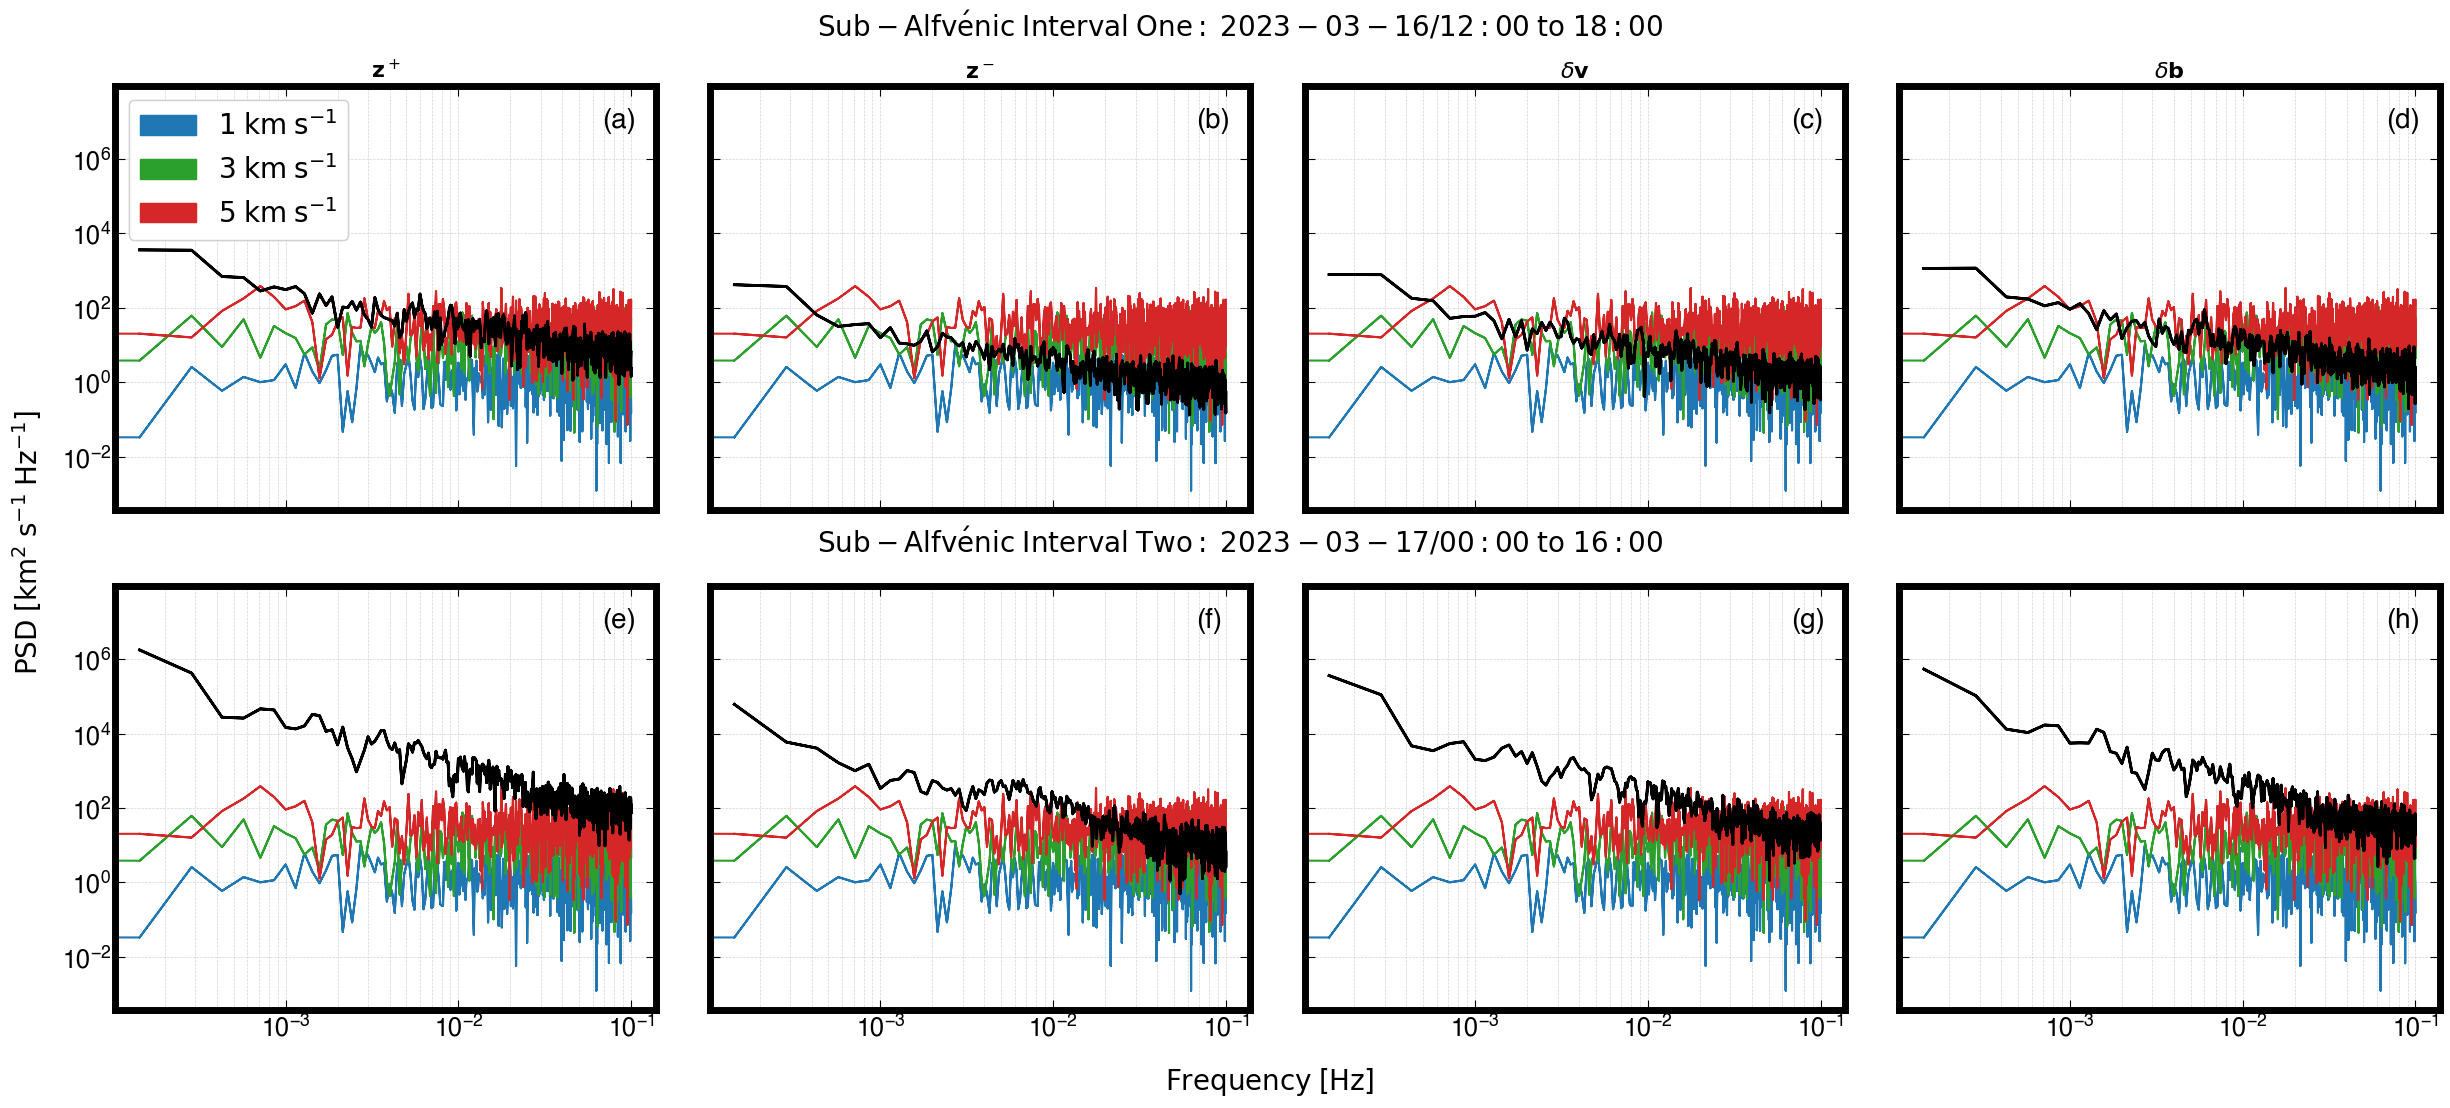

In [31]:
# Plot the PSD
lw=2
fig, axs = plt.subplots(2, 4, figsize=[30, 12], sharex='all', sharey='row', gridspec_kw={'wspace':0.1, 'hspace':0.18})
col = ['tab:blue', 'tab:green', 'tab:red']

labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']

##### ----- FAKE SPECTRA - PERIOD ONE ---- #####
axx = axs[0]
panels = ['(a)', '(b)', '(c)', '(d)']
for i, ax in enumerate(axx):
    ax.plot(freq, refspec[0], label=r'$\rm 1 \; km \; s^{-1}$', color=col[0])
    ax.plot(freq, refspec[1], label=r'$\rm 3 \; km \; s^{-1}$', color=col[1])
    ax.plot(freq, refspec[2], label=r'$\rm 5 \; km \; s^{-1}$', color=col[2])
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
    ax.tick_params(axis='both', which='major', labelsize=18) 
    ax.text(0.90, 0.95, panels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
    ax.set_xscale('log')  
    ax.set_yscale('log')  
        
##### ----- FAKE SPECTRA - PERIOD TWO ---- #####
axx = axs[1]
panels = ['(e)', '(f)', '(g)', '(h)']
for i, ax in enumerate(axx):
    ax.plot(freq, refspec[0], label=r'$\rm 1 \; km \; s^{-1}$', color=col[0])
    ax.plot(freq, refspec[1], label=r'$\rm 3 \; km \; s^{-1}$', color=col[1])
    ax.plot(freq, refspec[2], label=r'$\rm 5 \; km \; s^{-1}$', color=col[2])
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
    ax.tick_params(axis='both', which='major', labelsize=18) 
    ax.text(0.90, 0.95, panels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
    ax.set_xscale('log')  
    ax.set_yscale('log')  


##### ------ REAL SPECTRA - PERIOD ONE #####
freq = psd_Zp.freq
good = np.logical_and(np.array(freq)<=1, np.array(freq)>=1e-4)
for i, psd_spec in enumerate([psd_Zp, psd_Zm, psd_dv, psd_db]):
    axs[0][i].plot(psd_spec.freq[good], psd_spec.power[good], c='k', linewidth=lw, zorder=4)
    axs[0][i].set_title(labels[i])
    
##### ------ REAL SPECTRA - PERIOD TWO #####
freq = psd_Zp2.freq
good = np.logical_and(np.array(freq)<=1, np.array(freq)>=1e-4)
for i, psd_spec in enumerate([psd_Zp2, psd_Zm2, psd_dv2, psd_db2]):
    axs[1][i].plot(psd_spec.freq[good], psd_spec.power[good], c='k', linewidth=lw, zorder=4)

### ADD PANEL LABELS 
fig.text(0.09, 0.5, r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20, va='center', rotation='vertical')
fig.text(0.475, 0.05, r'$\rm Frequency \; [Hz]$', fontsize=20, va='center', rotation='horizontal')

### TITLES
fig.text(0.5, 0.93, r'$\rm Sub-Alfv\'enic \; Interval \; One: \; 2023-03-16/12:00 \; to \; 18:00$', fontsize=20, ha='center', va='center', rotation='horizontal') # period one
fig.text(0.5, 0.50, r'$\rm Sub-Alfv\'enic \; Interval \; Two: \; 2023-03-17/00:00 \; to \; 16:00$', fontsize=20, ha='center', va='center', rotation='horizontal') # period two

### LEGEND
ax = axs[0][0]
R_patch = mpatches.Patch(label=r'$\rm 1 \; km \; s^{-1}$', color=col[0])
T_patch = mpatches.Patch(label=r'$\rm 3 \; km \; s^{-1}$', color=col[1])
N_patch = mpatches.Patch(label=r'$\rm 5 \; km \; s^{-1}$', color=col[2])
leg0 = ax.legend(handles=[R_patch, T_patch, N_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)

plt.savefig(os.path.join(FIG_DIR, 'fig11.png'), bbox_inches='tight')
plt.savefig(os.path.join(EPS_DIR, 'fig11.eps'), bbox_inches='tight')


### Only One Period: Figure 11

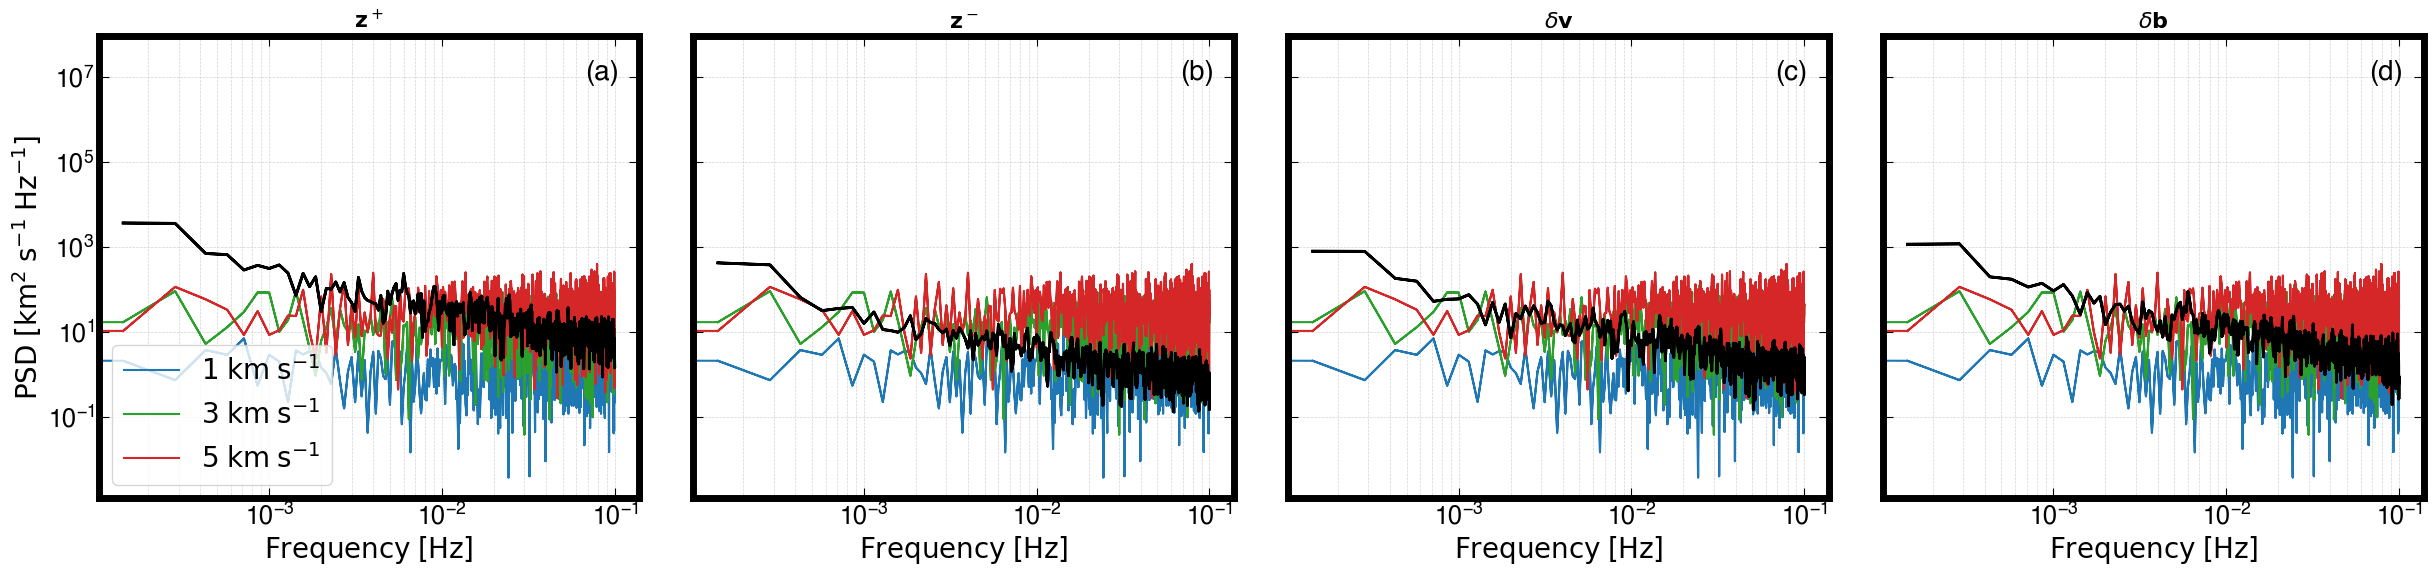

In [134]:
# Plot the PSD

fig, axs = plt.subplots(1, 4, figsize=[30, 6], sharex='all', sharey='all', gridspec_kw={'wspace':0.1})
col = ['tab:blue', 'tab:green', 'tab:red']
panels = ['(a)', '(b)', '(c)', '(d)']
labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']

##### ----- FAKE SPECTRA ---- #####
for i, ax in enumerate(axs):
    ax.plot(freq, refspec[0], label=r'$\rm 1 \; km \; s^{-1}$', color=col[0])
    ax.plot(freq, refspec[1], label=r'$\rm 3 \; km \; s^{-1}$', color=col[1])
    ax.plot(freq, refspec[2], label=r'$\rm 5 \; km \; s^{-1}$', color=col[2])
    ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
    ax.tick_params(axis='both', which='major', labelsize=18) 
    ax.text(0.90, 0.95, panels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
    ax.set_xscale('log')  
    ax.set_yscale('log')  
    ax.set_title(labels[i])

##### ------ REAL SPECTRA #####
for i, psd_spec in enumerate([psd_Zp, psd_Zm, psd_dv, psd_db]):
    axs[i].plot(psd_spec.freq[good], psd_spec.power[good], c='k', linewidth=lw, zorder=4)

### ADD PANEL LABELS
axs[0].set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)
axs[0].legend(loc='lower left', fontsize=20)


plt.savefig(os.path.join(FIG_DIR, 'fig11.png'), bbox_inches='tight')
plt.savefig(os.path.join(EPS_DIR, 'fig11.png'), bbox_inches='tight')
plt.show()

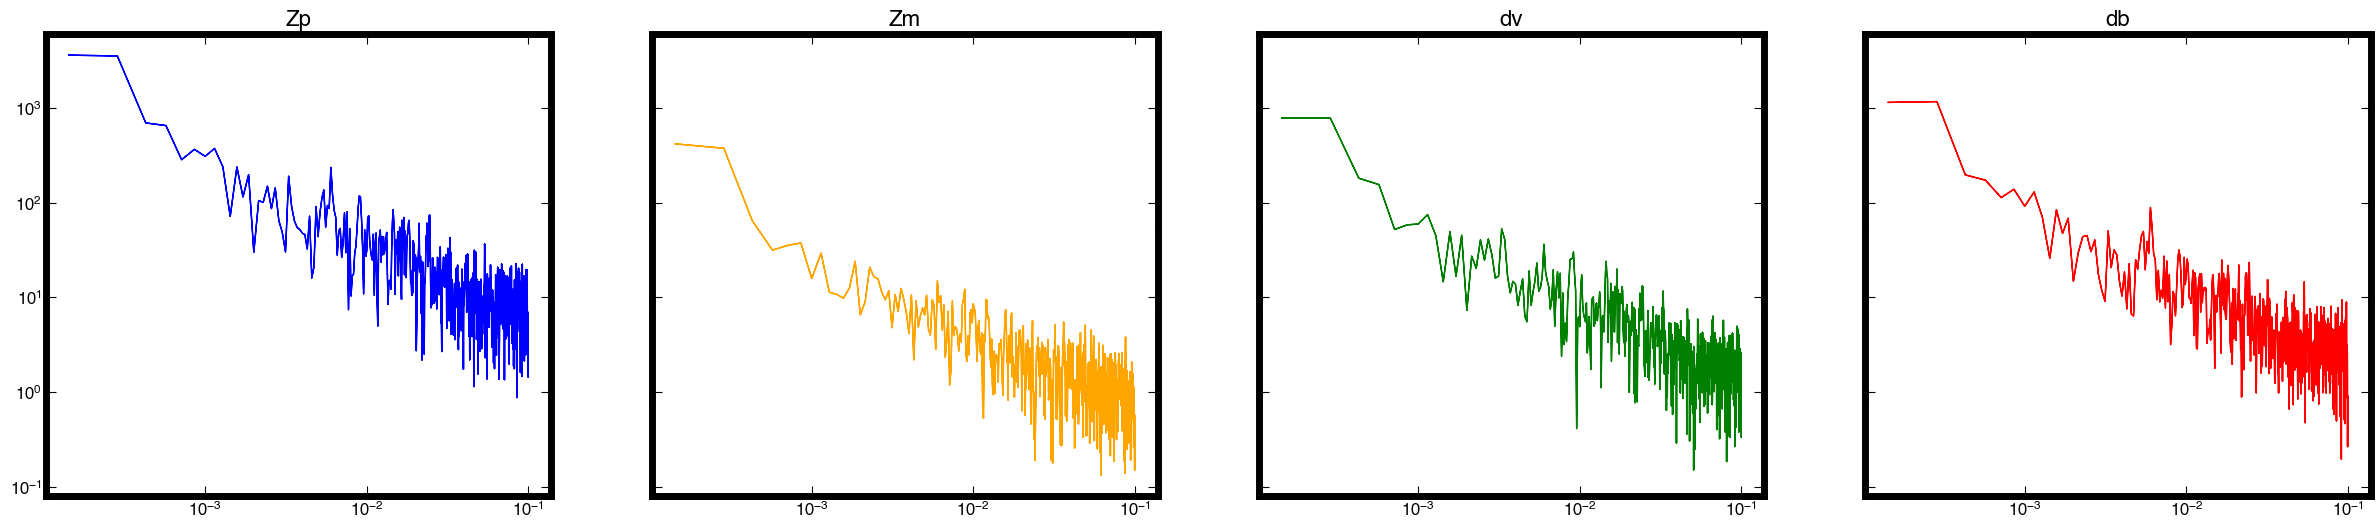

In [135]:
freq = psd_Zp.freq
good = np.logical_and(np.array(freq)<=1, np.array(freq)>=1e-4)
fig, axs = plt.subplots(1, 4, figsize=(30, 6), sharey='all')
titles = ['Zp', 'Zm', 'dv', 'db']
for i, psd_spec in enumerate([psd_Zp, psd_Zm, psd_dv, psd_db]):
    axs[i].plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i], label=labels[i], linewidth=1)
    axs[i].set_xscale('log')  
    axs[i].set_yscale('log')
    axs[i].set_title(titles[i])
# ax2.legend(loc='upper right')
# ax2.set_title('Power Spectral Density (PSD)')
# ax2.set_xlabel('Frequency (Hz)')
# ax2.grid(True)

# $\delta v$ Noise Comparison

1.) $\mathbf{z}^2_- - \delta \mathbf{b}^2 = \delta \mathbf{v}^2 - 2 \delta \mathbf{v} \cdot \delta \mathbf{b}$  
2.) Calculate PSD of above  
3.) Check if this reaches the noise floor

Text(0.5, 1.0, '$\\delta \\mathbf{v}^2 - 2 \\delta \\mathbf{v} \\cdot \\delta \\mathbf{b} $')

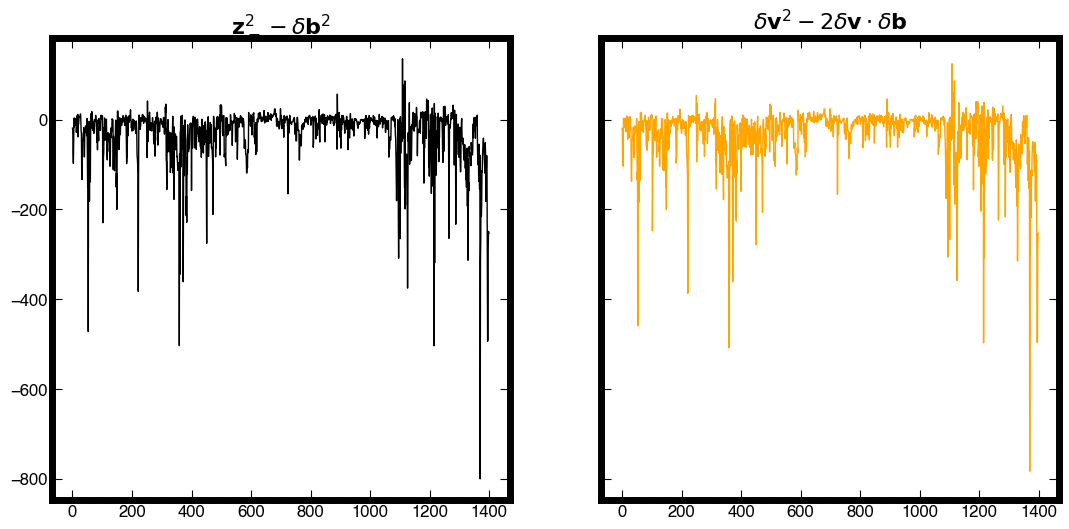

In [136]:
### ------ STEP ONE: $\mathbf{z}^2_- - \delta \mathbf{b}^2 = \delta \mathbf{v}^2 - 2 \delta \mathbf{v} \cdot \delta \mathbf{b}$ 

fig, axs = plt.subplots(1, 2, figsize=(13, 6), sharey='all')
titles = [r'$\mathbf{z}^2_- - \delta \mathbf{b}^2$', r'$\delta \mathbf{v}^2 - 2 \delta \mathbf{v} \cdot \delta \mathbf{b} $']

i=0
Zmdb = np.nanmean(tZm, axis=0)**2 - np.nanmean(tdb, axis=0)**2
axs[i].plot(Zmdb, c='k', linewidth=1)
axs[i].set_title(titles[i])

i=1
dvdb2 = (np.nanmean(tZp, axis=0)**2 - np.nanmean(tZm, axis=0)**2)/2
dvdot = np.nanmean(tdv, axis=0)**2 - dvdb2
axs[i].plot(dvdot, c=colors[i], label=labels[i], linewidth=1)
axs[i].set_title(titles[i])

In [137]:
### ------ STEP TWO: Calculate PSD

### Zmdb
Zmdb = [turb.Zm[i*ss:i*ss+ss]**2 - turb.deltab[i*ss:i*ss+ss]**2 for i in range(0, ii)]
psd_Zmdb = windowed_psd(Zmdb)

### dvdot
dvdot = [turb.deltav[i*ss:i*ss+ss]**2 - (turb.Zp[i*ss:i*ss+ss]**2 - turb.Zm[i*ss:i*ss+ss]**2)/2 for i in range(0, ii)]
psd_dvdot = windowed_psd(dvdot)

### PLOT PSD
freq = psd_Zp.freq
good = np.logical_and(np.array(freq)<=1, np.array(freq)>=1e-4)
fig, axs = plt.subplots(1, 4, figsize=(30, 6))
titles = [r'$\mathbf{z}^2_- - \delta \mathbf{b}^2$', r'$\delta \mathbf{v}^2 - 2 \delta \mathbf{v} \cdot \delta \mathbf{b} $',
          r'$\mathbf{z}^2_- - \delta \mathbf{b}^2$', r'$\delta \mathbf{v}^2 - 2 \delta \mathbf{v} \cdot \delta \mathbf{b} $']

i=0
# Zmdb = np.nanmean(tZm, axis=0)**2 - np.nanmean(tdb, axis=0)**2
axs[i].plot(Zmdb[5], c='k', linewidth=1)
# axs[i].plot(tZm**2 - tdb[5]**2)
axs[i].set_title(titles[i])

i=1
# dvdb2 = (np.nanmean(tZp, axis=0)**2 - np.nanmean(tZm, axis=0)**2)/2
# dvdot = np.nanmean(tdv, axis=0)**2 - dvdb2
axs[i].plot(dvdot[5], c=colors[i], label=labels[i], linewidth=1)
axs[i].set_title(titles[i])

i=2
axs[i].loglog(psd_Zmdb.freq, psd_Zmdb.power, c='k', linewidth=1)
axs[i].set_title(titles[i])

i=3
axs[i].loglog(psd_dvdot.freq, psd_dvdot.power, c=colors[i], label=labels[i], linewidth=1)
axs[i].set_title(titles[i])

ValueError: operands could not be broadcast together with shapes (6,1400) (6,) 

## Fourier Domain

$ \tilde{v}\tilde{v}* +\tilde{b}\tilde{b}* \pm (\tilde{v}\tilde{b}* +\tilde{v}*\tilde{b})$

In [ ]:
### CALCULATE Zp & Zm
N =  len(tdv[0])
vtild = np.fft.fft(tdv) # np.array(psd_dv.power)
vtildc = np.fft.fft(tdv).conj() # np.array(psd_dv.power).conj()
btild = np.fft.fft(tdb) # np.array(psd_db.power)
btildc = np.fft.fft(tdb).conj() #  np.array(psd_db.power).conj()
Zpf = vtild * vtildc + btild*btildc + (vtild * btildc + vtildc * btild)
Zpf = np.mean(Zpf, axis=0)/N
Zmf = vtild * vtildc + btild*btildc - (vtild * btildc + vtildc * btild)
Zmf = np.mean(Zmf, axis=0)/N

Gvv = (vtild * vtildc)
Gbb = (btild * btildc)
Gvb = (vtild * btildc + vtildc * btild)/2
coherence = np.abs(Gvb)**2 / (Gvv*Gbb)
coherence = np.mean(coherence, axis=0)

### CALCULATE UNNORMALIZED PSD FOR ZM AND ZP 
Zppsd = np.fft.fft(tZp) * np.fft.fft(tZp).conj()
Zppsd = np.abs(np.fft.fft(tZp))**2
Zppsd = np.mean(Zppsd, axis=0)/N

Zmpsd = np.fft.fft(tZm) * np.fft.fft(tZm).conj()
Zmpsd = np.abs(np.fft.fft(tZm))**2
Zmpsd = np.mean(Zmpsd, axis=0)/N

### PLOT# Plot the PSD
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=[20, 8], sharex='all', sharey='all', gridspec_kw={'hspace': 0.05, 'wspace':0.1})
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']
lw=2
##### -------- ELASSER SPECTRA #####
ax = ax1
good = np.logical_and(np.array(psd_Zp.freq)<=1, np.array(psd_Zp.freq)>=1e-4)
ax.plot(psd_Zp.freq[good], Zppsd[good], c=colors[0], label='Org Zp', linewidth=lw)
ax.plot(psd_Zp.freq[good], Zpf[good], c=colors[1], label='Fourier Zp', linewidth=lw)
ax.axvline(8e-2, c='k', linestyle='dashed', lw=2, zorder=0)

### LEGEND
ax.legend(loc='lower left', fontsize=20)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

##### -------- PANEL TWO: SPECTRAL FITS #####
freq = psd_Zp.freq
good = np.logical_and(np.array(freq)<=1, np.array(freq)>=1e-4)
ax = ax2
good = np.logical_and(np.array(psd_Zp.freq)<=1, np.array(psd_Zp.freq)>=1e-4)
ax.plot(psd_Zm.freq[good], Zmpsd[good], c=colors[0], label='Org Zm', linewidth=lw)
ax.plot(psd_Zm.freq[good], Zmf[good], c=colors[1], label='Fourier Zm', linewidth=lw)
ax.axvline(8e-2, c='k', linestyle='dashed', lw=2, zorder=0)

### LEGEND
ax.legend(loc='lower left', fontsize=20)

### LABELS
ax.text(0.92, 0.95, '(b)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 

### SCALES
ax2.set_xscale('log')  
ax2.set_yscale('log')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray', zorder=-4)
ax.axvline(8e-2, c='k', linestyle='dashed', lw=2, zorder=-1)

##### -------- PANEL THREE: SPECTRAL FITS #####
ax = ax3.twinx()
ax.loglog(psd_Zm.freq, coherence, c='k', lw=lw, label='Cross Spectra')
### LABELS
ax.text(0.92, 0.95, '(c)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray', zorder=-4)


# ##### ----- FAKE SPECTRA ---- #####
# col = ['tab:blue', 'tab:green', 'tab:red']
# refspec =[np.abs(np.fft.fft(tt))**2/N for tt in sn]
# # for i, ax in enumerate(axs):
# ax.plot(freq, refspec[0], label=r'$\rm 1 \; km \; s^{-1}$', color=col[0])
# ax.plot(freq, refspec[1], label=r'$\rm 3 \; km \; s^{-1}$', color=col[1])
# ax.plot(freq, refspec[2], label=r'$\rm 5 \; km \; s^{-1}$', color=col[2])
# ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
# ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
# ax.tick_params(axis='both', which='major', labelsize=18) 
# # ax.text(0.90, 0.95, panels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
# ax.set_xscale('log')  
# ax.set_yscale('log')  
# ax.set_title(labels[i])
# ax.legend()
### SAVE FIGURE
# plt.savefig(os.path.realpath(os.path.join(FIG_DIR, 'psd2.png')), bbox_inches='tight')

 
